# Documentation

**Author:** Anirudh  
**Date:** 30/04/2025  

### Details:
- **Modeling:** Using Linear mixed models now to study the longitudinal changes with respective to Diagnosis (Given BL_DX how cognitive changes overtime with sleep variables)
    - Two types of models to be made : 1. MRI, Cognitive, Sociodemographics. 2. MRI, Cognitive, APOE4, BMI, Cardiovascular risks [Using RID as random effect]
- **Transitions:** Check transitions for Diagnosis and NPIKSEV over time.
    - Flat = no changes 
    - Improves  
    - Worsen 
    - Mixed changes 
- **Changes:** 
    - Using Adjusted_Age instead of AGE.
    - Removing ICV as a covariate for MRI outcomes, instead using it as a predictor
    - Including Viscode/ Adjusted_Age in the model
    - Renamed model to have: outcome_sleep_var
    - Changed the plots now for each sleep_var inclusion
    - Saved the two models after including sociodemographic features into the 2nd model

In [1]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

In [2]:
volumes_data = pd.read_csv("Updated_merge.csv")
sleep_data = pd.read_csv("Updated_sleep.csv")
bmi = pd.read_csv("Updated_BMI.csv")

In [3]:
volumes_data = pd.merge(volumes_data, bmi,on='RID')

In [4]:
merge = pd.merge(volumes_data, sleep_data, on=['RID', 'VISCODE'])

In [5]:
merge = merge.drop(['MHDESC'],axis=1)

In [6]:
merge 

,VISCODE,RID,Brainstem,CorpusCallosumAnterior,CorpusCallosumCentral,CorpusCallosumMidAnterior,CorpusCallosumMidPosterior,CorpusCallosumPosterior,Csf,RightParacentral,...,ADNI_EF2,ICV,BMI,NPIK,NPIKSEV,Sleep_Apnea,Restless_Legs,Insomnia,Sleep_Disturbance_Other,Sleep_Quality
0,0,3,24577.0,790.0,375.0,341.0,307.0,735.0,1905.0,3539.0,...,-1.062,1920690.0,10.927769,0.0,0.0,0,0,0,0,2
1,1,3,23784.0,774.0,378.0,358.0,314.0,701.0,2022.0,3474.0,...,-0.670,1906430.0,10.927769,0.0,0.0,0,0,0,0,2
2,2,3,23759.0,763.0,369.0,323.0,307.0,721.0,2176.0,3234.0,...,-1.034,1903820.0,10.927769,0.0,0.0,0,0,0,0,2
3,3,3,23324.0,717.0,351.0,317.0,319.0,707.0,2023.0,3499.0,...,-1.605,1903420.0,10.927769,0.0,0.0,0,0,0,0,2
4,0,5,22015.0,960.0,451.0,470.0,368.0,1136.0,1423.0,2862.0,...,-0.152,1640770.0,12.273373,0.0,0.0,0,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2083,3,1425,18719.0,477.0,291.0,267.0,282.0,740.0,1191.0,2951.0,...,-0.826,1334060.0,42.458581,0.0,0.0,0,0,0,0,2
2084,0,1427,18408.0,920.0,365.0,418.0,395.0,938.0,1534.0,3121.0,...,-2.042,1515920.0,42.458581,0.0,0.0,0,0,0,0,2
2085,1,1427,18996.0,1001.0,392.0,438.0,348.0,902.0,1446.0,3287.0,...,-1.788,1549380.0,42.458581,0.0,0.0,0,0,0,0,2
2086,2,1427,18506.0,917.0,363.0,388.0,391.0,937.0,1470.0,3352.0,...,-2.047,1557540.0,42.458581,1.0,2.0,0,0,0,0,0


In [7]:
cognitive_outcomes = ['ADNI_MEM', 'ADNI_EF', 'ADNI_LAN', 'ADNI_VS', 'ADNI_EF2']
sleep_vars = ['NPIK', 'NPIKSEV', 'Sleep_Apnea',
              'Insomnia', 'Restless_Legs', 'Sleep_Disturbance_Other']
mri_outcomes = [
    "RightEntorhinal",
    "RightTemporalPole",
    "RightParahippocampal",
    "RightInferiorTemporal",
    "RightMiddleTemporal",
    "RightFusiform",
    "RightInferiorParietal",
    "RightIsthmusCingulate",
    "RightBankssts",
    "RightPrecuneus",
    "RightHippocampus",
    "RightAmygdala",
    "RightAccumbensArea",
    "RightMedialOrbitofrontal",
    "RightPallidum",
    "RightCaudalMiddleFrontal",
    "RightPutamen",
    "RightRostralAnteriorCingulate",
    "RightParacentral",
    "RightPrecentral",
    "RightLingual",
    "LeftEntorhinal",
    "LeftHippocampus",
    "LeftFusiform",
    "LeftMiddleTemporal",
    "LeftParacentral",
    "RightInferiorLateralVentricle",
    "LeftInferiorLateralVentricle",
    "RightLateralVentricle",
    "LeftLateralVentricle",
]

In [8]:
DX_bl ={0: "AD", 1: "CN", 2: "LMCI"}

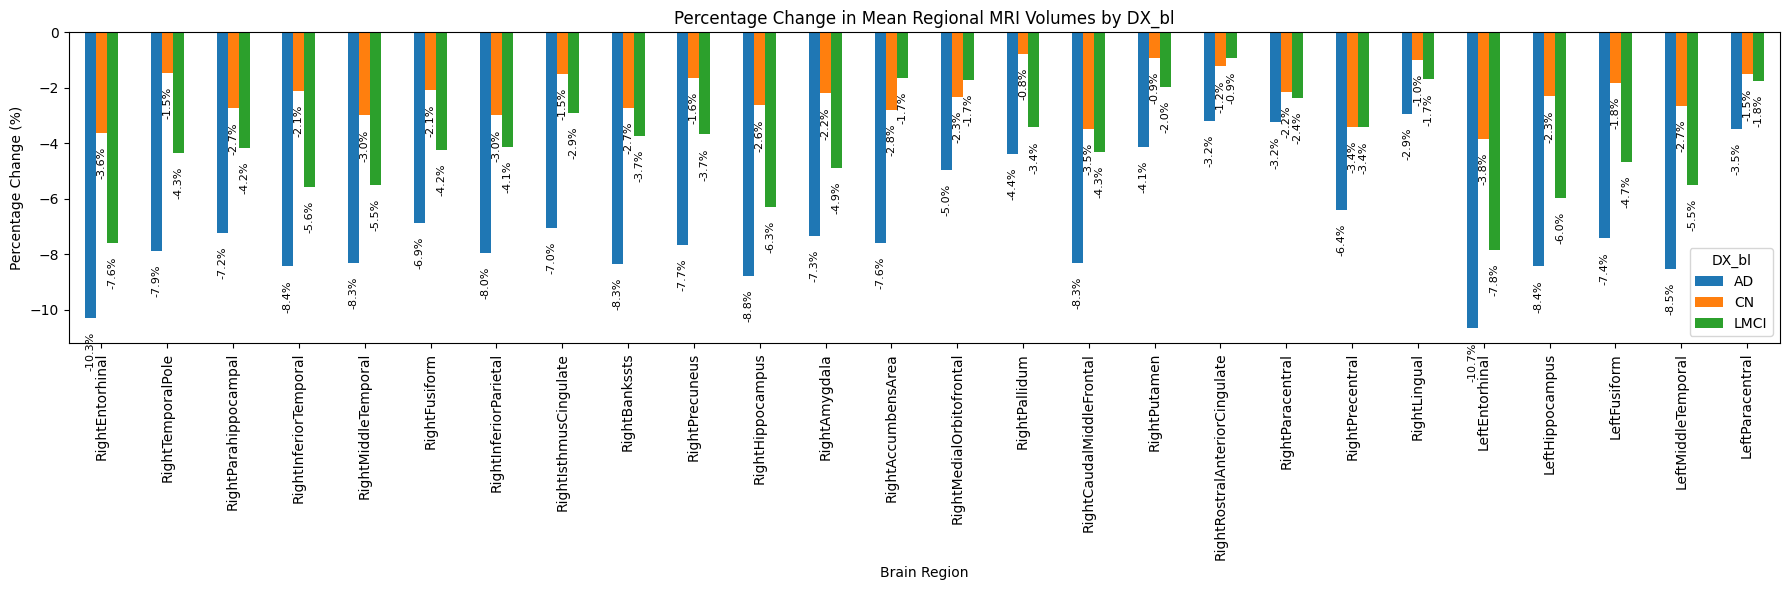

In [9]:
region_cols = [col for col in mri_outcomes if not col.endswith("Ventricle")]
viscode_map = {0: 'bl', 1: 'm06', 2: 'm12', 3: 'm24'}
merge['VISCODE_label'] = merge['VISCODE'].map(viscode_map)

mean_bl = merge[merge['VISCODE_label'] == 'bl'].groupby('DX_bl')[
    region_cols].mean()
mean_m24 = merge[merge['VISCODE_label'] == 'm24'].groupby('DX_bl')[
    region_cols].mean()

mean_bl = mean_bl.drop(columns=['Icv'], errors='ignore')
mean_m24 = mean_m24.drop(columns=['Icv'], errors='ignore')

pct_change = ((mean_m24 - mean_bl) / mean_bl) * 100

ax = pct_change.T.plot(kind='bar', figsize=(18, 6))
plt.title('Percentage Change in Mean Regional MRI Volumes by DX_bl')
plt.xlabel('Brain Region')
plt.ylabel('Percentage Change (%)')
plt.legend(title='DX_bl', labels=['AD', 'CN', 'LMCI'])
plt.tight_layout()

for p in ax.patches:
    height = p.get_height()
    if not np.isnan(height):
        ax.annotate(f'{height:.1f}%',
                    (p.get_x() + p.get_width() / 2, height),
                    ha='center', va='bottom' if height >= 0 else 'top',
                    fontsize=8, rotation=90, xytext=(0, 2 if height >= 0 else -10), textcoords='offset points')

plt.show()

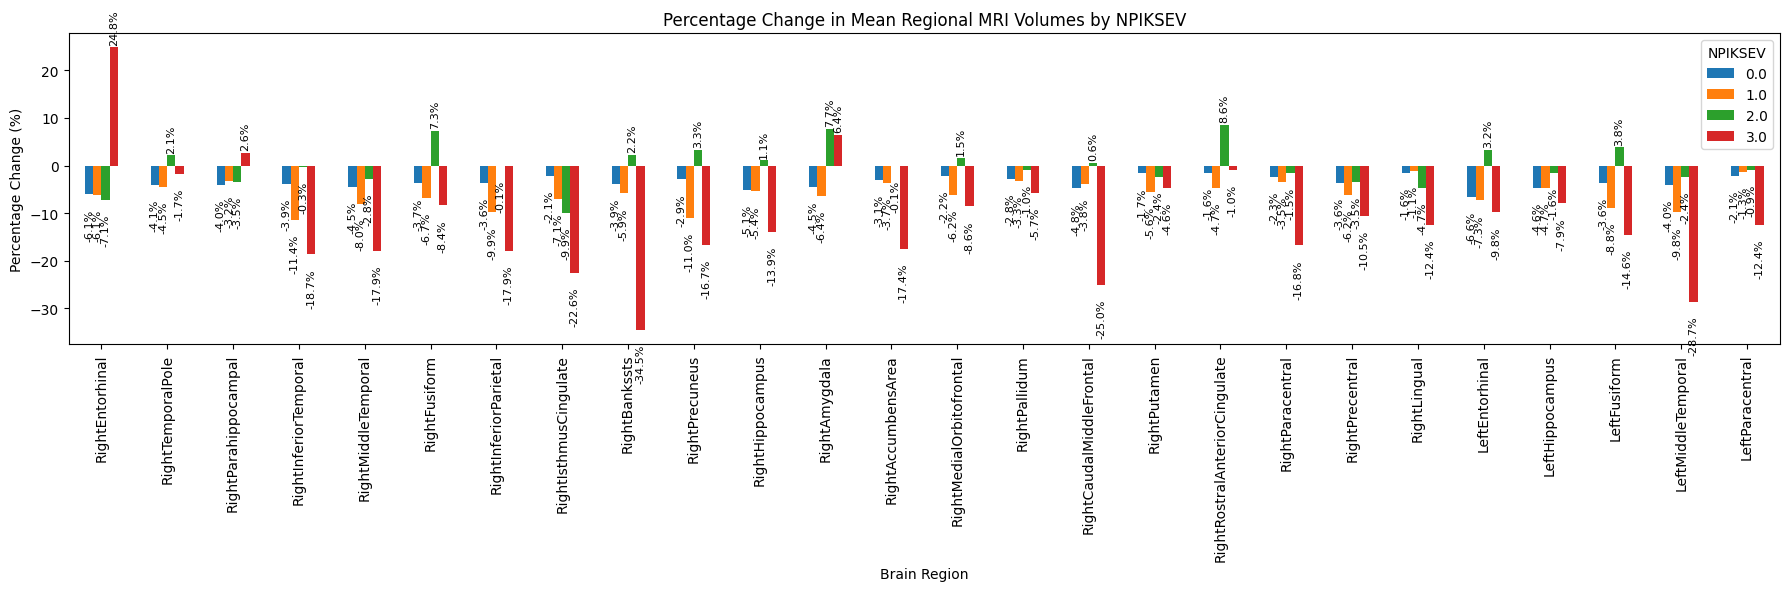

In [10]:
region_cols = [col for col in mri_outcomes if not col.endswith("Ventricle")]
viscode_map = {0: 'bl', 1: 'm06', 2: 'm12', 3: 'm24'}
merge['VISCODE_label'] = merge['VISCODE'].map(viscode_map)

mean_bl = merge[merge['VISCODE_label'] == 'bl'].groupby('NPIKSEV')[region_cols].mean()
mean_m24 = merge[merge['VISCODE_label'] == 'm24'].groupby('NPIKSEV')[region_cols].mean()

mean_bl = mean_bl.drop(columns=['Icv'], errors='ignore')
mean_m24 = mean_m24.drop(columns=['Icv'], errors='ignore')

pct_change = ((mean_m24 - mean_bl) / mean_bl) * 100

ax = pct_change.T.plot(kind='bar', figsize=(18, 6))
plt.title('Percentage Change in Mean Regional MRI Volumes by NPIKSEV')
plt.xlabel('Brain Region')
plt.ylabel('Percentage Change (%)')
plt.legend(title='NPIKSEV')
plt.tight_layout()

for p in ax.patches:
    height = p.get_height()
    if not np.isnan(height):
        ax.annotate(f'{height:.1f}%', 
                    (p.get_x() + p.get_width() / 2, height),
                    ha='center', va='bottom' if height >= 0 else 'top',
                    fontsize=8, rotation=90, xytext=(0, 2 if height >= 0 else -10), textcoords='offset points')

plt.show()

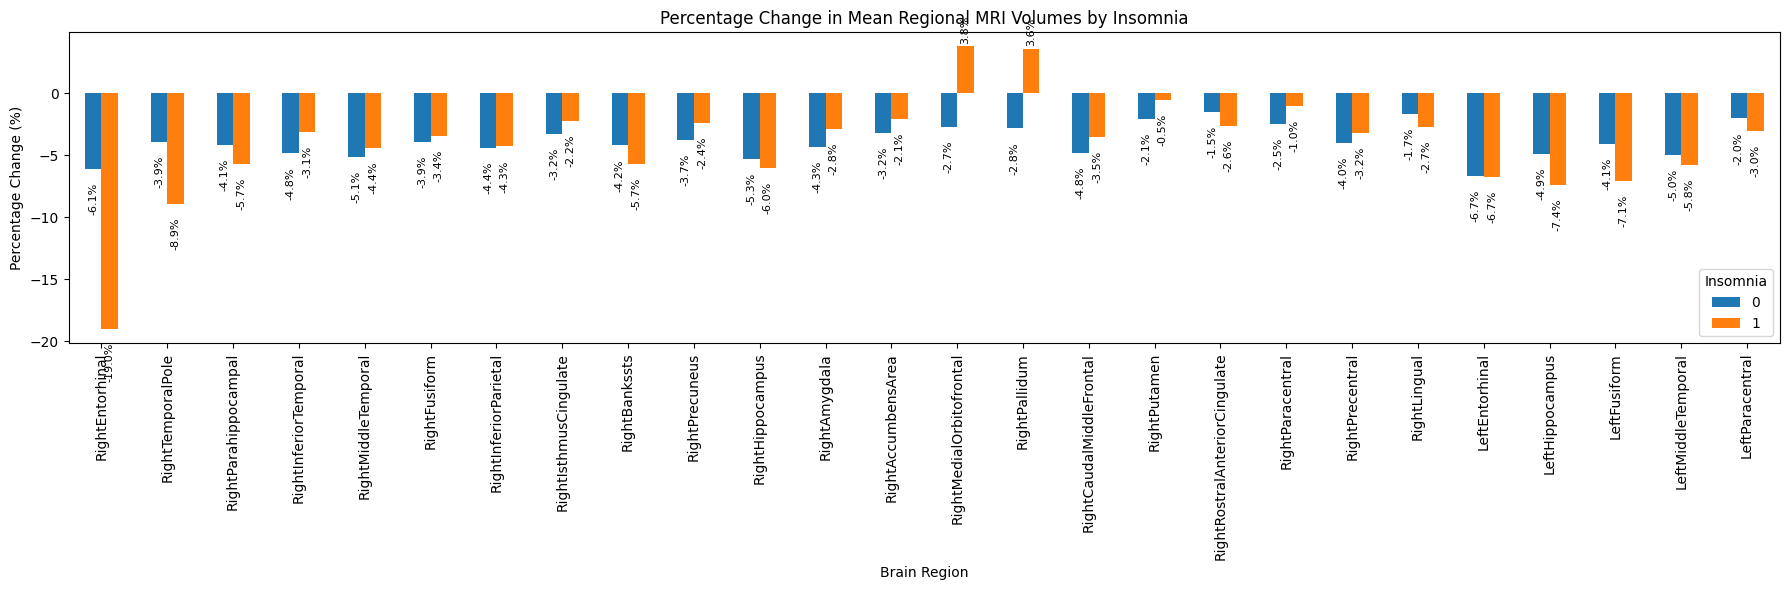

In [11]:
region_cols = [col for col in mri_outcomes if not col.endswith("Ventricle")]
viscode_map = {0: 'bl', 1: 'm06', 2: 'm12', 3: 'm24'}
merge['VISCODE_label'] = merge['VISCODE'].map(viscode_map)

mean_bl = merge[merge['VISCODE_label'] == 'bl'].groupby('Insomnia')[
    region_cols].mean()
mean_m24 = merge[merge['VISCODE_label'] == 'm24'].groupby('Insomnia')[
    region_cols].mean()

mean_bl = mean_bl.drop(columns=['Icv'], errors='ignore')
mean_m24 = mean_m24.drop(columns=['Icv'], errors='ignore')

pct_change = ((mean_m24 - mean_bl) / mean_bl) * 100

ax = pct_change.T.plot(kind='bar', figsize=(18, 6))
plt.title('Percentage Change in Mean Regional MRI Volumes by Insomnia')
plt.xlabel('Brain Region')
plt.ylabel('Percentage Change (%)')
plt.legend(title='Insomnia')
plt.tight_layout()

for p in ax.patches:
    height = p.get_height()
    if not np.isnan(height):
        ax.annotate(f'{height:.1f}%',
                    (p.get_x() + p.get_width() / 2, height),
                    ha='center', va='bottom' if height >= 0 else 'top',
                    fontsize=8, rotation=90, xytext=(0, 2 if height >= 0 else -10), textcoords='offset points')

plt.show()

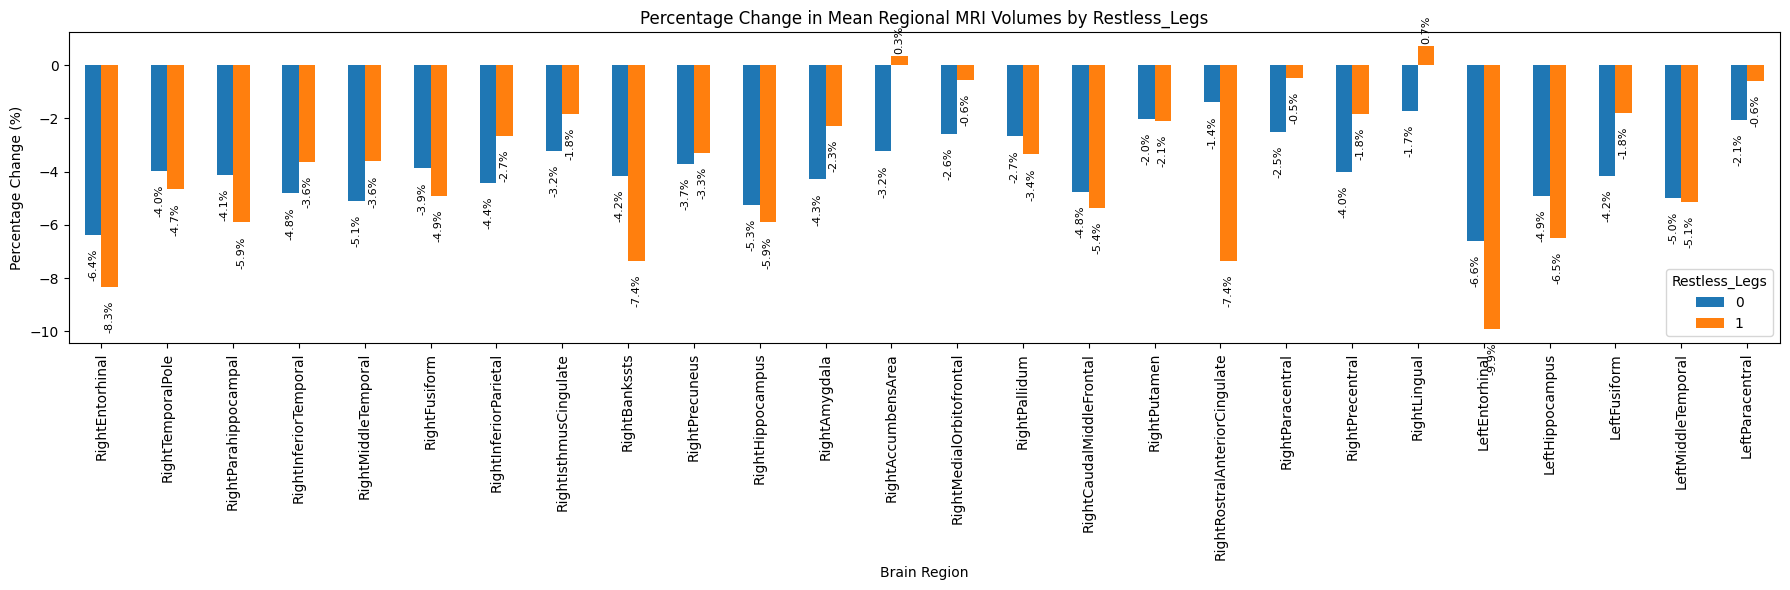

In [12]:
region_cols = [col for col in mri_outcomes if not col.endswith("Ventricle")]
viscode_map = {0: 'bl', 1: 'm06', 2: 'm12', 3: 'm24'}
merge['VISCODE_label'] = merge['VISCODE'].map(viscode_map)

mean_bl = merge[merge['VISCODE_label'] == 'bl'].groupby('Restless_Legs')[
    region_cols].mean()
mean_m24 = merge[merge['VISCODE_label'] == 'm24'].groupby('Restless_Legs')[
    region_cols].mean()

mean_bl = mean_bl.drop(columns=['Icv'], errors='ignore')
mean_m24 = mean_m24.drop(columns=['Icv'], errors='ignore')

pct_change = ((mean_m24 - mean_bl) / mean_bl) * 100

ax = pct_change.T.plot(kind='bar', figsize=(18, 6))
plt.title('Percentage Change in Mean Regional MRI Volumes by Restless_Legs')
plt.xlabel('Brain Region')
plt.ylabel('Percentage Change (%)')
plt.legend(title='Restless_Legs')
plt.tight_layout()

for p in ax.patches:
    height = p.get_height()
    if not np.isnan(height):
        ax.annotate(f'{height:.1f}%',
                    (p.get_x() + p.get_width() / 2, height),
                    ha='center', va='bottom' if height >= 0 else 'top',
                    fontsize=8, rotation=90, xytext=(0, 2 if height >= 0 else -10), textcoords='offset points')

plt.show()

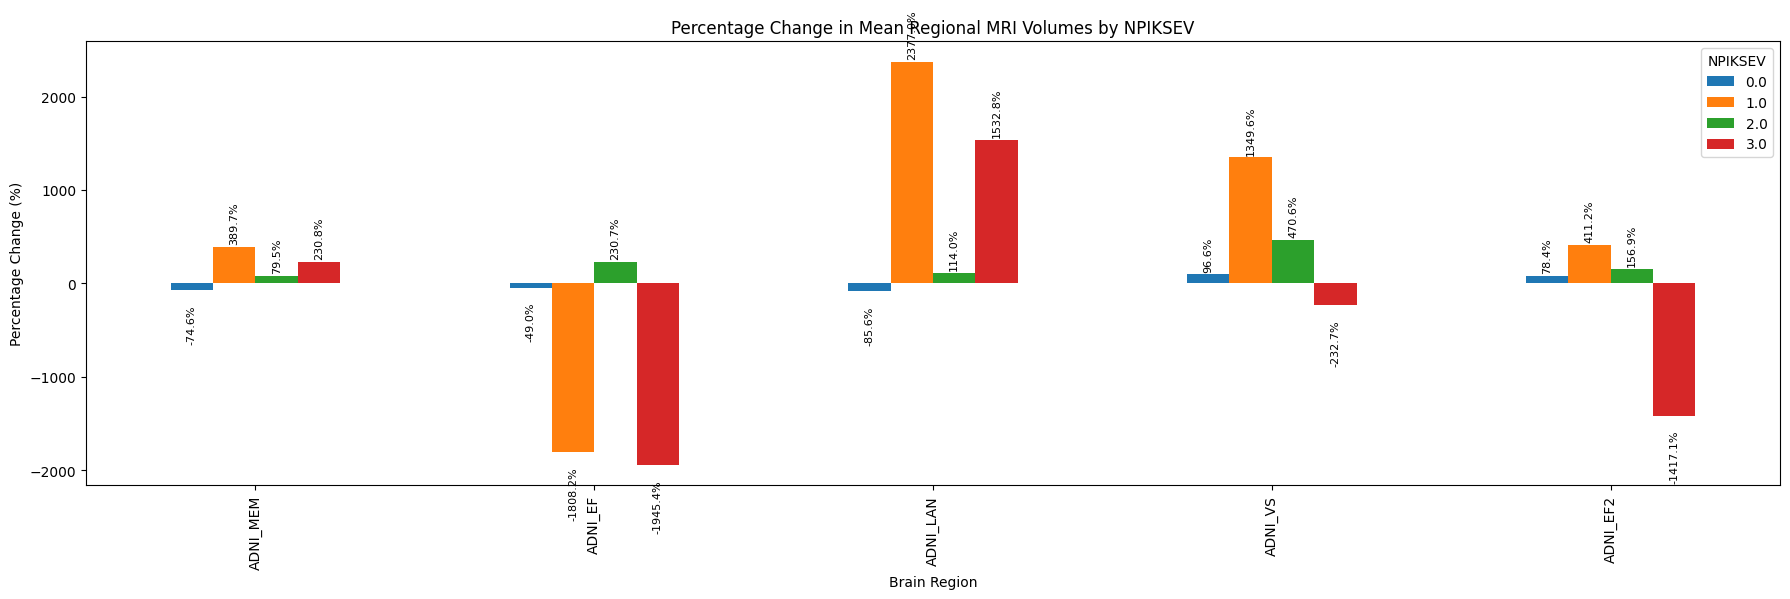

In [13]:
region_cols = cognitive_outcomes
viscode_map = {0: 'bl', 1: 'm06', 2: 'm12', 3: 'm24'}
merge['VISCODE_label'] = merge['VISCODE'].map(viscode_map)

mean_bl = merge[merge['VISCODE_label'] == 'bl'].groupby('NPIKSEV')[
    region_cols].mean()
mean_m24 = merge[merge['VISCODE_label'] == 'm24'].groupby('NPIKSEV')[
    region_cols].mean()

mean_bl = mean_bl.drop(columns=['Icv'], errors='ignore')
mean_m24 = mean_m24.drop(columns=['Icv'], errors='ignore')

pct_change = ((mean_m24 - mean_bl) / mean_bl) * 100

ax = pct_change.T.plot(kind='bar', figsize=(18, 6))
plt.title('Percentage Change in Mean Regional MRI Volumes by NPIKSEV')
plt.xlabel('Brain Region')
plt.ylabel('Percentage Change (%)')
plt.legend(title='NPIKSEV')
plt.tight_layout()

for p in ax.patches:
    height = p.get_height()
    if not np.isnan(height):
        ax.annotate(f'{height:.1f}%',
                    (p.get_x() + p.get_width() / 2, height),
                    ha='center', va='bottom' if height >= 0 else 'top',
                    fontsize=8, rotation=90, xytext=(0, 2 if height >= 0 else -10), textcoords='offset points')

plt.show()

In [14]:
set(merge.columns) - set(mri_outcomes) - set(cognitive_outcomes) - set(sleep_vars)

{'AGE',
 'APOE4',
 'Adjusted_Age',
 'BMI',
 'Brainstem',
 'CorpusCallosumAnterior',
 'CorpusCallosumCentral',
 'CorpusCallosumMidAnterior',
 'CorpusCallosumMidPosterior',
 'CorpusCallosumPosterior',
 'Csf',
 'DX',
 'DX_bl',
 'FourthVentricle',
 'ICV',
 'Icv',
 'LeftAccumbensArea',
 'LeftAmygdala',
 'LeftBankssts',
 'LeftCaudalAnteriorCingulate',
 'LeftCaudalMiddleFrontal',
 'LeftCaudate',
 'LeftCerebellumCortex',
 'LeftCerebellumWM',
 'LeftCerebralCortex',
 'LeftCerebralWM',
 'LeftChoroidPlexus',
 'LeftCuneus',
 'LeftFrontalPole',
 'LeftHemisphere',
 'LeftInferiorParietal',
 'LeftInferiorTemporal',
 'LeftInsula',
 'LeftIsthmusCingulate',
 'LeftLateralOccipital',
 'LeftLateralOrbitofrontal',
 'LeftLingual',
 'LeftMedialOrbitofrontal',
 'LeftPallidum',
 'LeftParahippocampal',
 'LeftParsOpercularis',
 'LeftParsOrbitalis',
 'LeftParsTriangularis',
 'LeftPericalcarine',
 'LeftPostcentral',
 'LeftPosteriorCingulate',
 'LeftPrecentral',
 'LeftPrecuneus',
 'LeftPutamen',
 'LeftRostralAnteriorC

In [15]:
merge.select_dtypes(include='object').columns.tolist()

['VISCODE_label']

In [16]:
from sklearn.preprocessing import StandardScaler

continuous_vars = (
    cognitive_outcomes + sleep_vars +
    mri_outcomes + ['BMI', 'Adjusted_Age']
)
merge_scaled = merge.copy()
scaler = StandardScaler()
merge_scaled[continuous_vars] = scaler.fit_transform(
    merge_scaled[continuous_vars])

In [17]:
categorical_vars = ['DX', 'PTRACCAT','DX_bl']
merge_scaled = pd.get_dummies(
    merge_scaled, columns=categorical_vars, drop_first=True)

In [18]:
set(merge_scaled.columns) - set(mri_outcomes) - \
    set(cognitive_outcomes) - set(sleep_vars)

{'AGE',
 'APOE4',
 'Adjusted_Age',
 'BMI',
 'Brainstem',
 'CorpusCallosumAnterior',
 'CorpusCallosumCentral',
 'CorpusCallosumMidAnterior',
 'CorpusCallosumMidPosterior',
 'CorpusCallosumPosterior',
 'Csf',
 'DX_1',
 'DX_2',
 'DX_bl_1',
 'DX_bl_2',
 'FourthVentricle',
 'ICV',
 'Icv',
 'LeftAccumbensArea',
 'LeftAmygdala',
 'LeftBankssts',
 'LeftCaudalAnteriorCingulate',
 'LeftCaudalMiddleFrontal',
 'LeftCaudate',
 'LeftCerebellumCortex',
 'LeftCerebellumWM',
 'LeftCerebralCortex',
 'LeftCerebralWM',
 'LeftChoroidPlexus',
 'LeftCuneus',
 'LeftFrontalPole',
 'LeftHemisphere',
 'LeftInferiorParietal',
 'LeftInferiorTemporal',
 'LeftInsula',
 'LeftIsthmusCingulate',
 'LeftLateralOccipital',
 'LeftLateralOrbitofrontal',
 'LeftLingual',
 'LeftMedialOrbitofrontal',
 'LeftPallidum',
 'LeftParahippocampal',
 'LeftParsOpercularis',
 'LeftParsOrbitalis',
 'LeftParsTriangularis',
 'LeftPericalcarine',
 'LeftPostcentral',
 'LeftPosteriorCingulate',
 'LeftPrecentral',
 'LeftPrecuneus',
 'LeftPutamen

In [19]:
model1_preds_mri = ['Adjusted_Age', 'PTEDUCAT',
                    'PTETHCAT',
                    'PTGENDER',
                    'PTMARRY',
                    'PTRACCAT_1',
                    'PTRACCAT_2',
                    'DX_1',
                    'DX_2',
                    'ICV']
model1_preds_cog = ['Adjusted_Age', 'PTEDUCAT',
                    'PTETHCAT',
                    'PTGENDER',
                    'PTMARRY',
                    'PTRACCAT_1',
                    'PTRACCAT_2',
                    'DX_1',
                    'DX_2',
                    ]

In [20]:
threshold = 10  
categorical_columns = [col for col in merge_scaled.columns if merge_scaled[col].nunique() <= threshold]

print(categorical_columns)

['VISCODE', 'PTGENDER', 'PTETHCAT', 'PTMARRY', 'APOE4', 'MHPSYCH', 'MH2NEURL', 'MH4CARD', 'MH5RESP', 'MH19OTHR', 'NPIK', 'NPIKSEV', 'Sleep_Apnea', 'Restless_Legs', 'Insomnia', 'Sleep_Disturbance_Other', 'Sleep_Quality', 'VISCODE_label', 'DX_1', 'DX_2', 'PTRACCAT_1', 'PTRACCAT_2', 'DX_bl_1', 'DX_bl_2']


In [21]:
categorical_mappings = {
    "VISCODE": {
        0: "bl", 1: "m06", 2: "m12", 3: "m24"
    },
    "DX_bl": {
        0: "AD", 1: "CN", 2: "LMCI"
    },
    "PTGENDER": {
        0: "Female", 1: "Male"
    },
    "PTETHCAT": {
        0: "Hisp/Latino", 1: "Not Hisp/Latino", 2: "Unknown"
    },
    "PTRACCAT_1": {
        0: "Asian", 1: "Black"
    },
    "PTRACCAT_2": {
        0:"Asian",  1: "White" },
    "PTMARRY": {
        0: "Divorced", 1: "Married", 2: "Never married", 3: "Unknown", 4: "Widowed"
    },
    "DX": {
        0: "CN", 1: "Dementia", 2: "MCI"
    },
    "Sleep_Quality": {
        0: "High Risk of Sleep Disturbance", 1: "Mild/Moderate Sleep Disturbance", 2: "No Significant Sleep Disturbance"
    },
    "APOE4": {
        0: "0", 1: "1 or 2"
    },
    "MHPSYCH": {
        0: "Absent", 1: "Present"
    },
    "MH2NEURL": {
        0: "Absent", 1: "Present"
    },
    "MH4CARD": {
        0: "Absent", 1: "Present"
    },
    "MH5RESP": {
        0: "Absent", 1: "Present"
    },
    "MH19OTHR": {
        0: "Absent", 1: "Present"
    },
    "NPIK": {
        0: "Absent", 1: "Present"
    },
    "NPIKSEV": {
        0: "Mild", 1: "Moderate", 2: "Severe"
    },
    "Sleep_Apnea": {
        0: "Absent", 1: "Present"
    },
    "Restless_Legs": {
        0: "Absent", 1: "Present"
    },
    "Insomnia": {
        0: "Absent", 1: "Present"
    },
    "Sleep_Disturbance_Other": {
        0: "Absent", 1: "Present"
    },
    "DX_1": {
        0: "CN", 1: "Dementia"
    },
    "DX_2": {
        0: "CN", 1: "MCI"
    }
}
rows = []
for col, mapping in categorical_mappings.items():
    for k, v in mapping.items():
        rows.append({"Column": col, "Encoded Value": k,
                    "Category Description": v})

categorical_df = pd.DataFrame(rows)

In [22]:
categorical_df.head()

,Column,Encoded Value,Category Description
0,VISCODE,0,bl
1,VISCODE,1,m06
2,VISCODE,2,m12
3,VISCODE,3,m24
4,DX_bl,0,AD


In [23]:
merge.groupby('DX')['RID'].nunique()

DX
0    189
1    200
2    248
Name: RID, dtype: int64

In [24]:
merge.groupby('DX_bl')['RID'].nunique()

DX_bl
0    106
1    178
2    238
Name: RID, dtype: int64

In [25]:
merge

,VISCODE,RID,Brainstem,CorpusCallosumAnterior,CorpusCallosumCentral,CorpusCallosumMidAnterior,CorpusCallosumMidPosterior,CorpusCallosumPosterior,Csf,RightParacentral,...,ICV,BMI,NPIK,NPIKSEV,Sleep_Apnea,Restless_Legs,Insomnia,Sleep_Disturbance_Other,Sleep_Quality,VISCODE_label
0,0,3,24577.0,790.0,375.0,341.0,307.0,735.0,1905.0,3539.0,...,1920690.0,10.927769,0.0,0.0,0,0,0,0,2,bl
1,1,3,23784.0,774.0,378.0,358.0,314.0,701.0,2022.0,3474.0,...,1906430.0,10.927769,0.0,0.0,0,0,0,0,2,m06
2,2,3,23759.0,763.0,369.0,323.0,307.0,721.0,2176.0,3234.0,...,1903820.0,10.927769,0.0,0.0,0,0,0,0,2,m12
3,3,3,23324.0,717.0,351.0,317.0,319.0,707.0,2023.0,3499.0,...,1903420.0,10.927769,0.0,0.0,0,0,0,0,2,m24
4,0,5,22015.0,960.0,451.0,470.0,368.0,1136.0,1423.0,2862.0,...,1640770.0,12.273373,0.0,0.0,0,0,0,0,2,bl
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2083,3,1425,18719.0,477.0,291.0,267.0,282.0,740.0,1191.0,2951.0,...,1334060.0,42.458581,0.0,0.0,0,0,0,0,2,m24
2084,0,1427,18408.0,920.0,365.0,418.0,395.0,938.0,1534.0,3121.0,...,1515920.0,42.458581,0.0,0.0,0,0,0,0,2,bl
2085,1,1427,18996.0,1001.0,392.0,438.0,348.0,902.0,1446.0,3287.0,...,1549380.0,42.458581,0.0,0.0,0,0,0,0,2,m06
2086,2,1427,18506.0,917.0,363.0,388.0,391.0,937.0,1470.0,3352.0,...,1557540.0,42.458581,1.0,2.0,0,0,0,0,0,m12


In [26]:
categorical_df[categorical_df['Column'] == 'DX_bl'].sort_values(by='Encoded Value')

,Column,Encoded Value,Category Description
4,DX_bl,0,AD
5,DX_bl,1,CN
6,DX_bl,2,LMCI


In [27]:
feature_rename_map = {
    'DX_1': 'Dx_AD',
    'DX_2': 'Dx_MCI',
    'PTGENDER': 'Sex',
    'PTEDUCAT': 'Education',
    'AGE': 'Age',
    'PTRACCAT_1': 'Black',
    'PTRACCAT_2': 'White',
    'PTETHCAT': 'Ethnicity',
    'PTMARRY': 'Marital Status',
    'APOE4': 'APOE4',
    'BMI': 'BMI',
    'MH19OTHR': 'Other_MH',
    'MH2NEURL': 'Neurological',
    'MH4CARD': 'Cardiovascular',
    'MH5RESP': 'Respiratory',
    'MHPSYCH': 'Psychiatric'
}

In [28]:
from collections import defaultdict

sleep_model_results = {
    'cognitive': defaultdict(list),
    'mri': defaultdict(list)
}

model_counter = 1


def store_all_predictors(result, outcome, sleep_var, domain):
    records = []
    for predictor in result.params.index:
        records.append({
            'Model_ID': f"model_{model_counter}",
            'Outcome': outcome,
            'Sleep_Variable': sleep_var,
            'Feature': predictor,
            'Coefficient': result.params.get(predictor, float('nan')),
            'P-Value': result.pvalues.get(predictor, float('nan')),
        })
    return records


for sleep_var in sleep_vars:
    for outcome in cognitive_outcomes:
        try:
            formula = f"{outcome} ~ {sleep_var} + {' + '.join(model1_preds_cog)}"
            model = smf.mixedlm(formula, data=merge_scaled,
                                groups=merge_scaled["RID"])
            result = model.fit(reml=False)

            results = store_all_predictors(
                result, outcome, sleep_var, 'cognitive')
            sleep_model_results['cognitive'][sleep_var].extend(results)
            model_counter += 1
        except Exception as e:
            print(f"[Cognitive] Error for {outcome} with {sleep_var}: {e}")

for sleep_var in sleep_vars:
    for outcome in mri_outcomes:
        try:
            formula = f"{outcome} ~ {sleep_var} + {' + '.join(model1_preds_mri)}"
            model = smf.mixedlm(formula, data=merge_scaled,
                                groups=merge_scaled["RID"])
            result = model.fit(reml=False)

            results = store_all_predictors(result, outcome, sleep_var, 'mri')
            sleep_model_results['mri'][sleep_var].extend(results)
            model_counter += 1
        except Exception as e:
            print(f"[MRI] Error for {outcome} with {sleep_var}: {e}")

In [82]:
import pickle
for sleep_var in sleep_vars:
    with open(f"Models/cognitive_outcomes_{sleep_var}.pkl", 'wb') as f:
        pickle.dump(sleep_model_results['cognitive'][sleep_var], f)

    with open(f"Models/mri_outcomes_{sleep_var}.pkl", 'wb') as f:
        pickle.dump(sleep_model_results['mri'][sleep_var], f)

In [83]:
LMM_results_cognitive_df = pd.DataFrame(sleep_model_results['cognitive'])
LMM_results_mri_df = pd.DataFrame(sleep_model_results['mri'])

In [84]:
import pickle

cog_frames = []
for sleep_var in sleep_vars:
    with open(f"Models/cognitive_outcomes_{sleep_var}.pkl", 'rb') as f:
        cognitive_results = pickle.load(f)
        cog_frames.append(pd.DataFrame(cognitive_results))

LMM_results_cognitive_df = pd.concat(cog_frames, ignore_index=True)

mri_frames = []
for sleep_var in sleep_vars:
    with open(f"Models/mri_outcomes_{sleep_var}.pkl", 'rb') as f:
        mri_results = pickle.load(f)
        mri_frames.append(pd.DataFrame(mri_results))

LMM_results_mri_df = pd.concat(mri_frames, ignore_index=True)

In [85]:
LMM_results_cognitive_df 

,Model_ID,Outcome,Sleep_Variable,Feature,Coefficient,P-Value
0,model_1,ADNI_MEM,NPIK,Intercept,0.027022,9.330092e-01
1,model_1,ADNI_MEM,NPIK,NPIK,-0.000664,9.389768e-01
2,model_1,ADNI_MEM,NPIK,APOE4,-0.196257,1.611871e-06
3,model_1,ADNI_MEM,NPIK,BMI,0.012386,6.392220e-01
4,model_1,ADNI_MEM,NPIK,MH,-0.046577,5.260363e-02
...,...,...,...,...,...,...
445,model_30,ADNI_EF2,Sleep_Disturbance_Other,PTRACCAT_1,-0.652359,3.149769e-02
446,model_30,ADNI_EF2,Sleep_Disturbance_Other,PTRACCAT_2,-0.365659,1.512669e-01
447,model_30,ADNI_EF2,Sleep_Disturbance_Other,DX_1,-0.925107,5.251285e-50
448,model_30,ADNI_EF2,Sleep_Disturbance_Other,DX_2,-0.521925,2.523179e-21


In [86]:
flat_cog = LMM_results_cognitive_df[~LMM_results_cognitive_df['Feature'].isin(['Intercept', 'Group Var'])]
flat_mri = LMM_results_mri_df[~LMM_results_mri_df['Feature'].isin(['Intercept', 'Group Var'])]

In [87]:
feature_rename_map = {
    'DX_1': 'Dx_AD',
    'DX_2': 'Dx_MCI',
    'PTGENDER': 'Sex',
    'PTEDUCAT': 'Education',
    'AGE': 'Age',
    'PTRACCAT': 'Race',
    'PTETHCAT': 'Ethnicity',
    'PTMARRY': 'Marital Status',
    'APOE4': 'APOE4',
    'BMI': 'BMI',
    'MH19OTHR': 'Other_MH',
    'MH2NEURL': 'Neurological',
    'MH4CARD': 'Cardiovascular',
    'MH5RESP': 'Respiratory',
    'MHPSYCH': 'Psychiatric',
    'PTRACCAT_1': 'Black',
    'PTRACCAT_2': 'White',
}

In [88]:
flat_cog['Feature'] = flat_cog['Feature'].replace(feature_rename_map)

C:\Users\anisr\AppData\Local\Temp\ipykernel_17716\542403301.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [89]:
flat_mri['Feature'] = flat_mri['Feature'].replace(feature_rename_map)

C:\Users\anisr\AppData\Local\Temp\ipykernel_17716\3056705490.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [90]:
# for sleep_var in flat_cog['Sleep_Variable'].unique():
#     df_plot = flat_cog[flat_cog['Sleep_Variable'] == sleep_var]

#     plt.figure(figsize=(10, 8))
#     sns.barplot(
#         data=df_plot,
#         x='Coefficient',
#         y='Outcome',
#         hue='Feature',
#         dodge=True,
#         palette='tab10'
#     )

#     plt.axvline(x=0, color='red', linestyle='--')
#     plt.title(
#         f'LMM Coefficients for {sleep_var} + Covariates on Cognitive Outcomes')
#     plt.xlabel('Coefficient')
#     plt.ylabel('Cognitive Outcome')
#     plt.legend(title='Predictor', bbox_to_anchor=(1.05, 1), loc='upper left')
#     plt.tight_layout()

In [91]:
print(sleep_data[sleep_data['VISCODE'] == 0]['Sleep_Apnea'].value_counts())
print(sleep_data[sleep_data['VISCODE'] == 0]['Restless_Legs'].value_counts())
print(sleep_data[sleep_data['VISCODE'] == 0]['Insomnia'].value_counts())
print(sleep_data[sleep_data['VISCODE'] == 0]['Sleep_Disturbance_Other'].value_counts())

0    492
1     30
Name: Sleep_Apnea, dtype: int64
0    514
1      8
Name: Restless_Legs, dtype: int64
0    510
1     12
Name: Insomnia, dtype: int64
0    518
1      4
Name: Sleep_Disturbance_Other, dtype: int64


In [92]:
for vis in sleep_data['VISCODE'].unique():
    print(sleep_data[sleep_data['VISCODE'] == vis]['NPIK'].value_counts())

0.0    456
1.0     63
2.0      3
Name: NPIK, dtype: int64
0.0    435
1.0     83
2.0      4
Name: NPIK, dtype: int64
0.0    425
1.0     93
2.0      4
Name: NPIK, dtype: int64
 0.0    416
 1.0     93
 2.0     12
-1.0      1
Name: NPIK, dtype: int64


In [93]:
for vis in sleep_data['VISCODE'].unique():
    print(sleep_data[sleep_data['VISCODE'] == vis]['NPIKSEV'].value_counts())

0.0    459
1.0     48
2.0     13
3.0      2
Name: NPIKSEV, dtype: int64
0.0    439
1.0     57
2.0     22
3.0      4
Name: NPIKSEV, dtype: int64
0.0    429
1.0     58
2.0     30
3.0      5
Name: NPIKSEV, dtype: int64
0.0    429
1.0     54
2.0     29
3.0     10
Name: NPIKSEV, dtype: int64


In [94]:
pivot_df = flat_cog.pivot_table(
    index="Outcome",
    columns="Sleep_Variable",
    values=["Coefficient", "P-Value"],
    aggfunc="first"
)
pivot_df.columns = [f"{var}_{sv}" for var, sv in pivot_df.columns]
pivot_df.reset_index(inplace=True)

for sv in sleep_vars:
    coef_col = f"Coefficient_{sv}"
    pval_col = f"P-Value_{sv}"
    if coef_col in pivot_df.columns and pval_col in pivot_df.columns:
        pivot_df[sv] = pivot_df.apply(
            lambda row: (
                f"{row[coef_col]:.2f} (p={row[pval_col]:.2f})"
                if pd.notnull(row[coef_col]) else ""
            ),
            axis=1
        )
    else:
        pivot_df[sv] = ""

In [95]:
final_df = pivot_df[["Outcome"] + sleep_vars]
final_df.index.name = "Cognitive Outcome"

In [96]:
final_df 

,Outcome,NPIK,NPIKSEV,Sleep_Apnea,Restless_Legs,Insomnia,Sleep_Disturbance_Other
Cognitive Outcome,,,,,,,
0,ADNI_EF,-0.00 (p=0.61),-0.00 (p=0.66),-0.00 (p=0.90),0.02 (p=0.55),0.03 (p=0.28),-0.00 (p=0.97)
1,ADNI_EF2,-0.01 (p=0.43),-0.00 (p=0.76),-0.00 (p=0.92),0.02 (p=0.51),0.03 (p=0.41),0.00 (p=0.97)
2,ADNI_LAN,-0.02 (p=0.07),-0.04 (p=0.00),-0.01 (p=0.69),-0.00 (p=0.96),0.04 (p=0.19),0.03 (p=0.38)
3,ADNI_MEM,-0.00 (p=0.94),-0.01 (p=0.12),-0.01 (p=0.78),-0.02 (p=0.53),0.01 (p=0.74),0.01 (p=0.72)
4,ADNI_VS,-0.03 (p=0.09),-0.03 (p=0.13),-0.00 (p=0.97),-0.00 (p=0.97),0.00 (p=0.95),-0.01 (p=0.66)


In [97]:
pivot_df = flat_mri.pivot_table(
    index="Outcome",
    columns="Sleep_Variable",
    values=["Coefficient", "P-Value"],
    aggfunc="first"
)
pivot_df.columns = [f"{var}_{sv}" for var, sv in pivot_df.columns]
pivot_df.reset_index(inplace=True)

for sv in sleep_vars:
    coef_col = f"Coefficient_{sv}"
    pval_col = f"P-Value_{sv}"
    if coef_col in pivot_df.columns and pval_col in pivot_df.columns:
        pivot_df[sv] = pivot_df.apply(
            lambda row: (
                f"{row[coef_col]:.2f} (p={row[pval_col]:.2f})"
                if pd.notnull(row[coef_col]) else ""
            ),
            axis=1
        )
    else:
        pivot_df[sv] = ""

In [98]:
final_df = pivot_df[["Outcome"] + sleep_vars]
final_df

,Outcome,NPIK,NPIKSEV,Sleep_Apnea,Restless_Legs,Insomnia,Sleep_Disturbance_Other
0,LeftEntorhinal,0.01 (p=0.44),-0.01 (p=0.54),0.01 (p=0.83),-0.01 (p=0.74),-0.01 (p=0.84),-0.01 (p=0.67)
1,LeftFusiform,-0.01 (p=0.56),-0.01 (p=0.21),-0.01 (p=0.70),0.04 (p=0.22),0.03 (p=0.34),-0.01 (p=0.83)
2,LeftHippocampus,-0.00 (p=0.91),0.00 (p=0.68),0.04 (p=0.33),0.01 (p=0.68),0.03 (p=0.44),-0.00 (p=0.90)
3,LeftInferiorLateralVentricle,0.00 (p=0.40),0.02 (p=0.00),-0.01 (p=0.82),-0.05 (p=0.24),-0.02 (p=0.56),0.02 (p=0.66)
4,LeftLateralVentricle,0.00 (p=0.60),0.01 (p=0.00),-0.00 (p=0.96),-0.06 (p=0.14),-0.00 (p=0.93),0.03 (p=0.45)
5,LeftMiddleTemporal,-0.01 (p=0.06),-0.01 (p=0.14),0.00 (p=0.98),0.01 (p=0.88),0.04 (p=0.21),0.00 (p=0.91)
6,LeftParacentral,-0.02 (p=0.08),-0.01 (p=0.17),0.03 (p=0.48),0.01 (p=0.83),0.04 (p=0.30),0.05 (p=0.18)
7,RightAccumbensArea,0.01 (p=0.44),0.00 (p=0.84),-0.00 (p=0.90),0.09 (p=0.01),0.05 (p=0.15),0.04 (p=0.32)
8,RightAmygdala,-0.01 (p=0.45),-0.01 (p=0.11),0.02 (p=0.65),0.04 (p=0.27),0.04 (p=0.27),0.02 (p=0.46)
9,RightBankssts,-0.01 (p=0.39),-0.01 (p=0.44),0.04 (p=0.32),0.02 (p=0.56),0.01 (p=0.86),-0.02 (p=0.54)


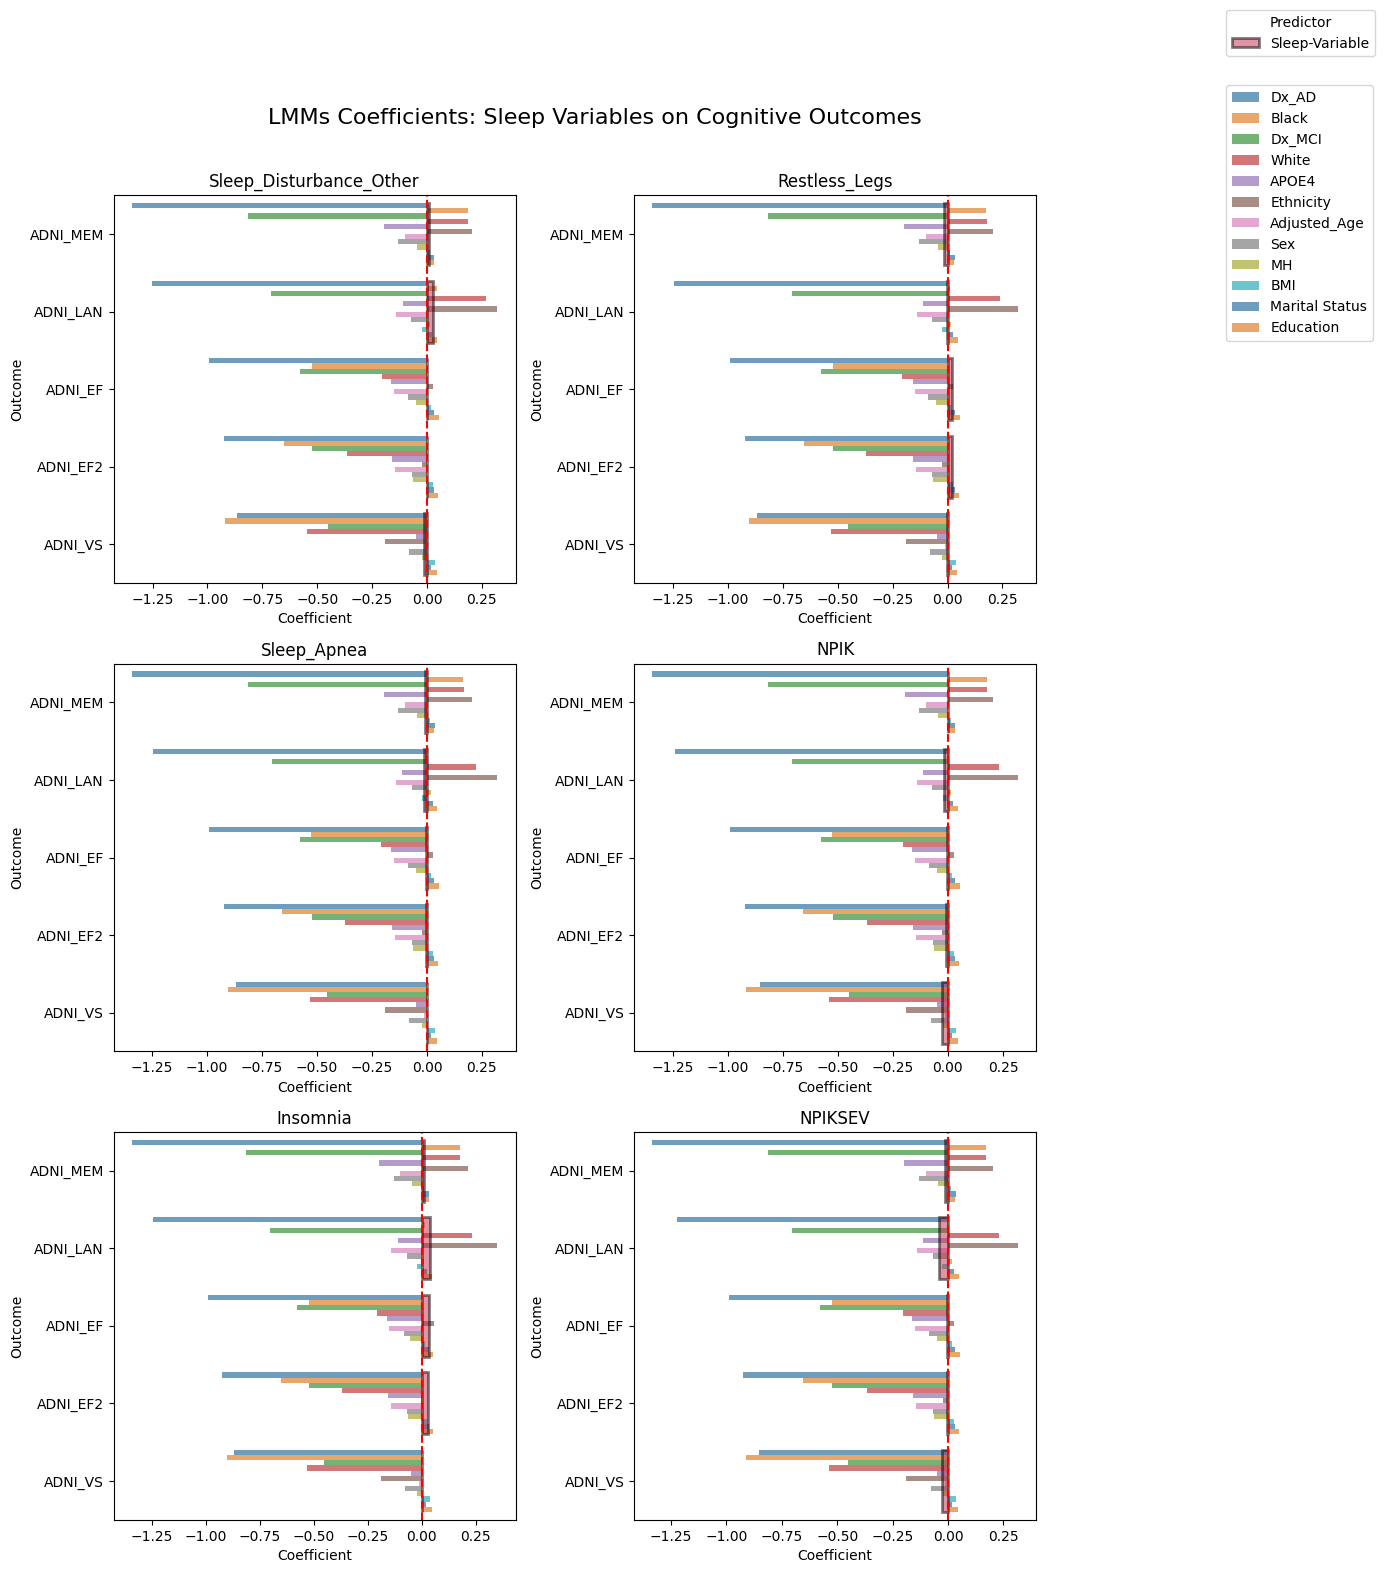

In [99]:
import math


def plot_lmms_result(df, domain='Cognitive', n_cols=2):
    sleep_vars = df['Sleep_Variable'].unique()
    n_plots = len(sleep_vars)
    n_rows = math.ceil(n_plots / n_cols)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(
        n_cols*6, n_rows*5), squeeze=False)

    for idx, sleep_var in enumerate(sleep_vars):
        row, col = divmod(idx, n_cols)
        ax = axes[row][col]

        df_plot = df[df['Sleep_Variable'] == sleep_var]
        sleep_feat = sleep_var

        df_others = df_plot[df_plot['Feature'] != sleep_feat]
        sns.barplot(
            data=df_others,
            x='Coefficient',
            y='Outcome',
            hue='Feature',
            dodge=True,
            palette='tab10',
            ax=ax,
            alpha=0.7
        )

        df_sleep = df_plot[df_plot['Feature'] == sleep_feat]
        if not df_sleep.empty:
            sns.barplot(
                data=df_sleep,
                x='Coefficient',
                y='Outcome',
                color='crimson',
                ax=ax,
                label=sleep_feat,
                dodge=True,
                alpha=0.5,
                linewidth=2,
                edgecolor='black'
            )

        ax.axvline(x=0, color='red', linestyle='--')
        ax.set_title(f'{sleep_var}', fontsize=12)
        ax.set_xlabel('Coefficient')
        ax.set_ylabel('Outcome')
        ax.legend_.remove()

    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels[:-1],
               bbox_to_anchor=(1.02, 1), loc='upper left')
               
    fig.legend([handles[-1]], ['Sleep-Variable'], title='Predictor',
               bbox_to_anchor=(1.02, 1.05), loc='upper left')
    fig.suptitle(
        f'LMMs Coefficients: Sleep Variables on {domain} Outcomes', fontsize=16)
    plt.tight_layout(rect=[0, 0, 0.88, 0.97])
    plt.show()

plot_lmms_result(flat_cog.sort_values(by='Coefficient'), domain='Cognitive', n_cols=2)

In [47]:
# for sleep_var in flat_mri['Sleep_Variable'].unique():
#     df_plot = flat_mri[flat_mri['Sleep_Variable'] == sleep_var]

#     top_outcomes = (
#         df_plot[df_plot['Feature'] == sleep_var]
#         .set_index('Outcome')['Coefficient']
#         .abs()
#         .sort_values(ascending=False)
#         .head(5)
#         .index
#     )

#     df_top = df_plot[df_plot['Outcome'].isin(top_outcomes)]

#     plt.figure(figsize=(10, 8))
#     sns.barplot(
#         data=df_top,
#         x='Coefficient',
#         y='Outcome',
#         hue='Feature',
#         dodge=True,
#         palette='Set2'
#     )

#     plt.axvline(x=0, color='red', linestyle='--')
#     plt.title(
#         f'LMM Coefficients for {sleep_var} + Covariates on Top 5 MRI Outcomes')
#     plt.xlabel('Coefficient')
#     plt.ylabel('MRI Outcome')
#     plt.legend(title='Predictor', bbox_to_anchor=(1.05, 1), loc='upper left')
#     plt.tight_layout()

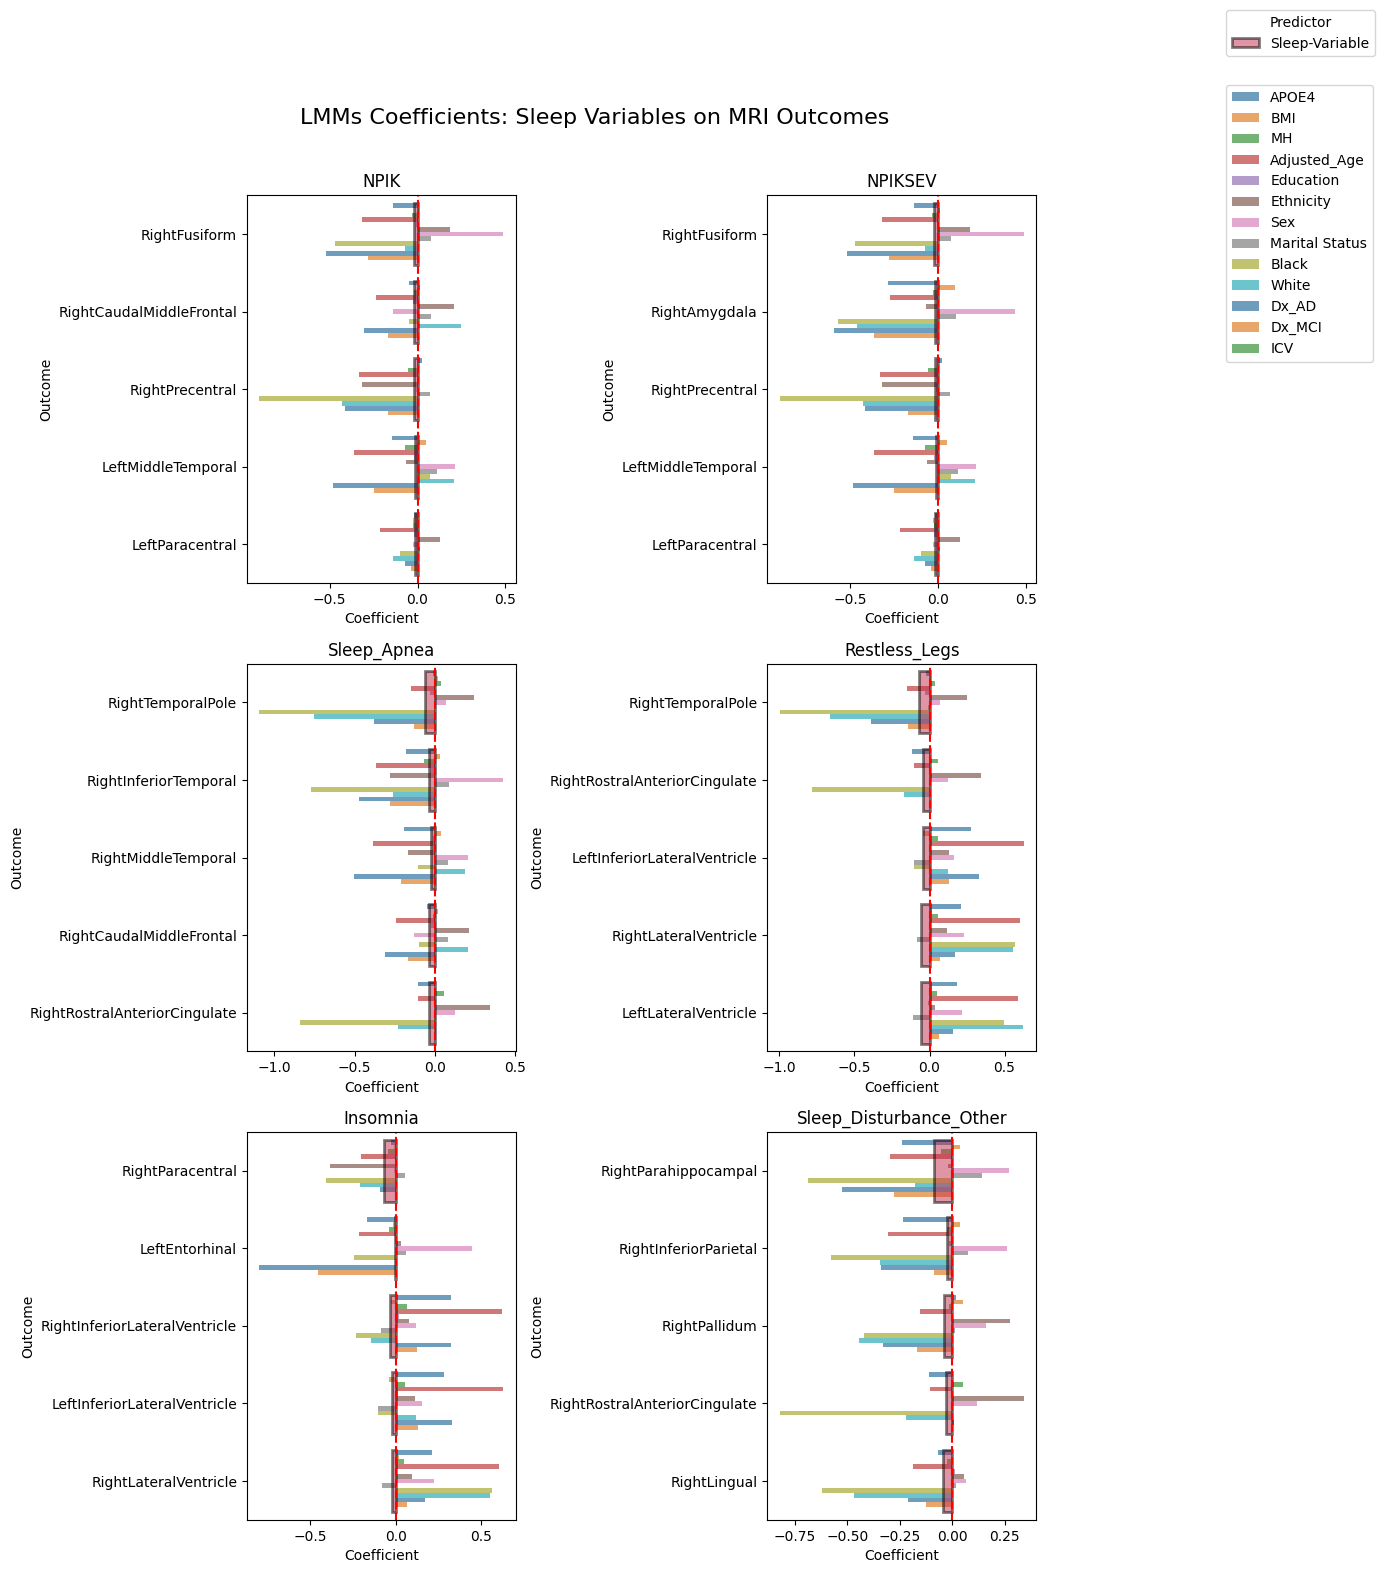

In [100]:
all_df_top = []

for sleep_var in flat_mri['Sleep_Variable'].unique():
    df_plot = flat_mri[flat_mri['Sleep_Variable'] == sleep_var]

    top_outcomes = (
        df_plot[df_plot['Feature'] == sleep_var].sort_values(by='Coefficient')
        .set_index('Outcome')['Coefficient']
        .abs()
        .head(5)
        .index
    )

    df_top = df_plot[df_plot['Outcome'].isin(top_outcomes)]
    all_df_top.append(df_top)

df_top_all = pd.concat(all_df_top, ignore_index=True)
plot_lmms_result(df_top_all, domain='MRI')

In [101]:
mh_cols = ["MH19OTHR", "MH2NEURL", "MH4CARD", "MH5RESP", "MHPSYCH"]
merge_scaled["MH"] = merge_scaled[mh_cols].sum(axis=1)

In [102]:
model2_preds_cog = ['APOE4', 'BMI','MH',] + model1_preds_cog
model2_preds_mri = ['APOE4', 'BMI', 'MH',] + model1_preds_mri

In [103]:
from collections import defaultdict
sleep_model_results = {
    'cognitive': defaultdict(list),
    'mri': defaultdict(list)
}
model_counter = 1
def store_all_predictors(result, outcome, sleep_var, domain):
    records = []
    for predictor in result.params.index:
        records.append({
            'Model_ID': f"model_{model_counter}",
            'Outcome': outcome,
         'Sleep_Variable': sleep_var,
            'Feature': predictor,
            'Coefficient': result.params.get(predictor, float('nan')),
            'P-Value': result.pvalues.get(predictor, float('nan')),
        })
    return records

for sleep_var in sleep_vars:
    for outcome in cognitive_outcomes:
        try:
            formula = f"{outcome} ~ {sleep_var} + {' + '.join(model2_preds_cog)}"
            model = smf.mixedlm(formula, data=merge_scaled,
                                groups=merge_scaled["RID"])
            result = model.fit(reml=False)
            results = store_all_predictors(
                result, outcome, sleep_var, 'cognitive')
            sleep_model_results['cognitive'][sleep_var].extend(results)
            model_counter += 1
        except Exception as e:
            print(f"[Cognitive] Error for {outcome} with {sleep_var}: {e}")

for sleep_var in sleep_vars:
    for outcome in mri_outcomes:
        try:
            formula = f"{outcome} ~ {sleep_var} + {' + '.join(model2_preds_mri)}"
            model = smf.mixedlm(formula, data=merge_scaled,
                                groups=merge_scaled["RID"])
            result = model.fit(reml=False)
            results = store_all_predictors(result, outcome, sleep_var, 'mri')
            sleep_model_results['mri'][sleep_var].extend(results)
            model_counter += 1
        except Exception as e:
            print(f"[MRI] Error for {outcome} with {sleep_var}: {e}")

In [104]:
import pickle
for sleep_var in sleep_vars:
    with open(f"Models/cognitive_outcomes_{sleep_var}_sd.pkl", 'wb') as f:
        pickle.dump(sleep_model_results['cognitive'][sleep_var], f)

    with open(f"Models/mri_outcomes_{sleep_var}_sd.pkl", 'wb') as f:
        pickle.dump(sleep_model_results['mri'][sleep_var], f)

In [105]:
cog_frames = []
mri_frames = []

for sleep_var in sleep_vars:
    with open(f"Models/cognitive_outcomes_{sleep_var}_sd.pkl", 'rb') as f:
        cognitive_results = pickle.load(f)
        cog_frames.append(pd.DataFrame(cognitive_results))

    with open(f"Models/mri_outcomes_{sleep_var}_sd.pkl", 'rb') as f:
        mri_results = pickle.load(f)
        mri_frames.append(pd.DataFrame(mri_results))

LMM_results_cognitive_df_sd = pd.concat(cog_frames, ignore_index=True)
LMM_results_mri_df_sd = pd.concat(mri_frames, ignore_index=True)

In [106]:
LMM_results_cognitive_df_sd = LMM_results_cognitive_df_sd[~LMM_results_cognitive_df_sd['Feature'].isin( ['Group Var','Intercept'])]
LMM_results_mri_df_sd = LMM_results_mri_df_sd[~LMM_results_mri_df_sd['Feature'].isin( ['Group Var', 'Intercept'])]

In [107]:
LMM_results_cognitive_df_sd['Feature'] = LMM_results_cognitive_df_sd['Feature'].replace(feature_rename_map)
LMM_results_mri_df_sd['Feature'] = LMM_results_mri_df_sd['Feature'].replace(feature_rename_map)

In [108]:
pivot_df = LMM_results_cognitive_df_sd.pivot_table(
    index="Outcome",
    columns="Sleep_Variable",
    values=["Coefficient", "P-Value"],
    aggfunc="first"
)
pivot_df.columns = [f"{var}_{sv}" for var, sv in pivot_df.columns]
pivot_df.reset_index(inplace=True)

for sv in sleep_vars:
    coef_col = f"Coefficient_{sv}"
    pval_col = f"P-Value_{sv}"
    if coef_col in pivot_df.columns and pval_col in pivot_df.columns:
        pivot_df[sv] = pivot_df.apply(
            lambda row: (
                f"{row[coef_col]:.2f} (p={row[pval_col]:.2f})"
                if pd.notnull(row[coef_col]) else ""
            ),
            axis=1
        )
    else:
        pivot_df[sv] = ""

final_df = pivot_df[["Outcome"] + sleep_vars]
final_df.index.name = "Cognitive Outcome"
final_df

,Outcome,NPIK,NPIKSEV,Sleep_Apnea,Restless_Legs,Insomnia,Sleep_Disturbance_Other
Cognitive Outcome,,,,,,,
0,ADNI_EF,-0.00 (p=0.61),-0.00 (p=0.66),-0.00 (p=0.90),0.02 (p=0.55),0.03 (p=0.28),-0.00 (p=0.97)
1,ADNI_EF2,-0.01 (p=0.43),-0.00 (p=0.76),-0.00 (p=0.92),0.02 (p=0.51),0.03 (p=0.41),0.00 (p=0.97)
2,ADNI_LAN,-0.02 (p=0.07),-0.04 (p=0.00),-0.01 (p=0.69),-0.00 (p=0.96),0.04 (p=0.19),0.03 (p=0.38)
3,ADNI_MEM,-0.00 (p=0.94),-0.01 (p=0.12),-0.01 (p=0.78),-0.02 (p=0.53),0.01 (p=0.74),0.01 (p=0.72)
4,ADNI_VS,-0.03 (p=0.09),-0.03 (p=0.13),-0.00 (p=0.97),-0.00 (p=0.97),0.00 (p=0.95),-0.01 (p=0.66)


In [109]:
pivot_df = LMM_results_mri_df_sd.pivot_table(
    index="Outcome",
    columns="Sleep_Variable",
    values=["Coefficient", "P-Value"],
    aggfunc="first"
)
pivot_df.columns = [f"{var}_{sv}" for var, sv in pivot_df.columns]
pivot_df.reset_index(inplace=True)

for sv in sleep_vars:
    coef_col = f"Coefficient_{sv}"
    pval_col = f"P-Value_{sv}"
    if coef_col in pivot_df.columns and pval_col in pivot_df.columns:
        pivot_df[sv] = pivot_df.apply(
            lambda row: (
                f"{row[coef_col]:.2f} (p={row[pval_col]:.2f})"
                if pd.notnull(row[coef_col]) else ""
            ),
            axis=1
        )
    else:
        pivot_df[sv] = ""

final_df = pivot_df[["Outcome"] + sleep_vars]
final_df.index.name = "Cognitive Outcome"
final_df

,Outcome,NPIK,NPIKSEV,Sleep_Apnea,Restless_Legs,Insomnia,Sleep_Disturbance_Other
Cognitive Outcome,,,,,,,
0,LeftEntorhinal,0.01 (p=0.44),-0.01 (p=0.54),0.01 (p=0.83),-0.01 (p=0.74),-0.01 (p=0.84),-0.01 (p=0.67)
1,LeftFusiform,-0.01 (p=0.56),-0.01 (p=0.21),-0.01 (p=0.70),0.04 (p=0.22),0.03 (p=0.34),-0.01 (p=0.83)
2,LeftHippocampus,-0.00 (p=0.91),0.00 (p=0.68),0.04 (p=0.33),0.01 (p=0.68),0.03 (p=0.44),-0.00 (p=0.90)
3,LeftInferiorLateralVentricle,0.00 (p=0.40),0.02 (p=0.00),-0.01 (p=0.82),-0.05 (p=0.24),-0.02 (p=0.56),0.02 (p=0.66)
4,LeftLateralVentricle,0.00 (p=0.60),0.01 (p=0.00),-0.00 (p=0.96),-0.06 (p=0.14),-0.00 (p=0.93),0.03 (p=0.45)
5,LeftMiddleTemporal,-0.01 (p=0.06),-0.01 (p=0.14),0.00 (p=0.98),0.01 (p=0.88),0.04 (p=0.21),0.00 (p=0.91)
6,LeftParacentral,-0.02 (p=0.08),-0.01 (p=0.17),0.03 (p=0.48),0.01 (p=0.83),0.04 (p=0.30),0.05 (p=0.18)
7,RightAccumbensArea,0.01 (p=0.44),0.00 (p=0.84),-0.00 (p=0.90),0.09 (p=0.01),0.05 (p=0.15),0.04 (p=0.32)
8,RightAmygdala,-0.01 (p=0.45),-0.01 (p=0.11),0.02 (p=0.65),0.04 (p=0.27),0.04 (p=0.27),0.02 (p=0.46)


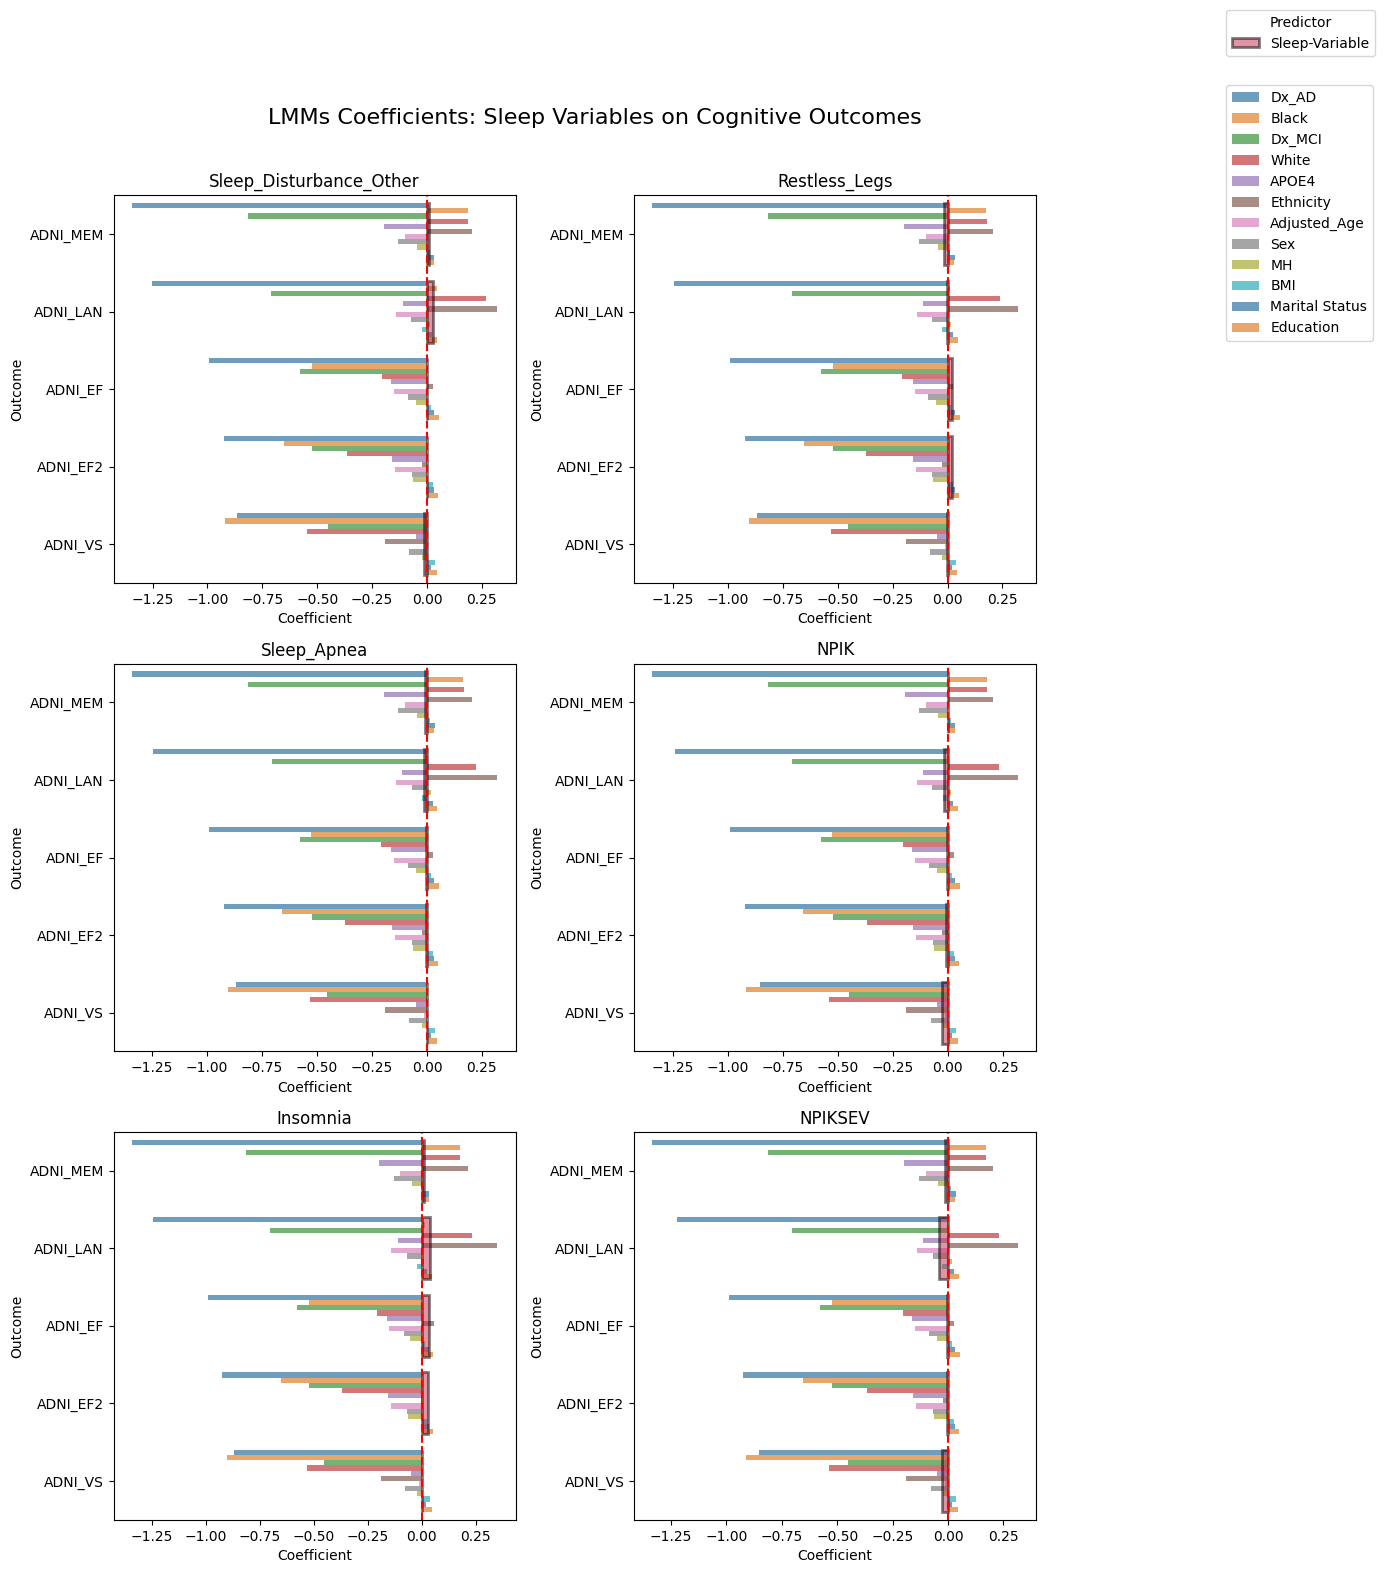

In [110]:
plot_lmms_result(LMM_results_cognitive_df_sd.sort_values(by='Coefficient'), domain='Cognitive', n_cols=2)

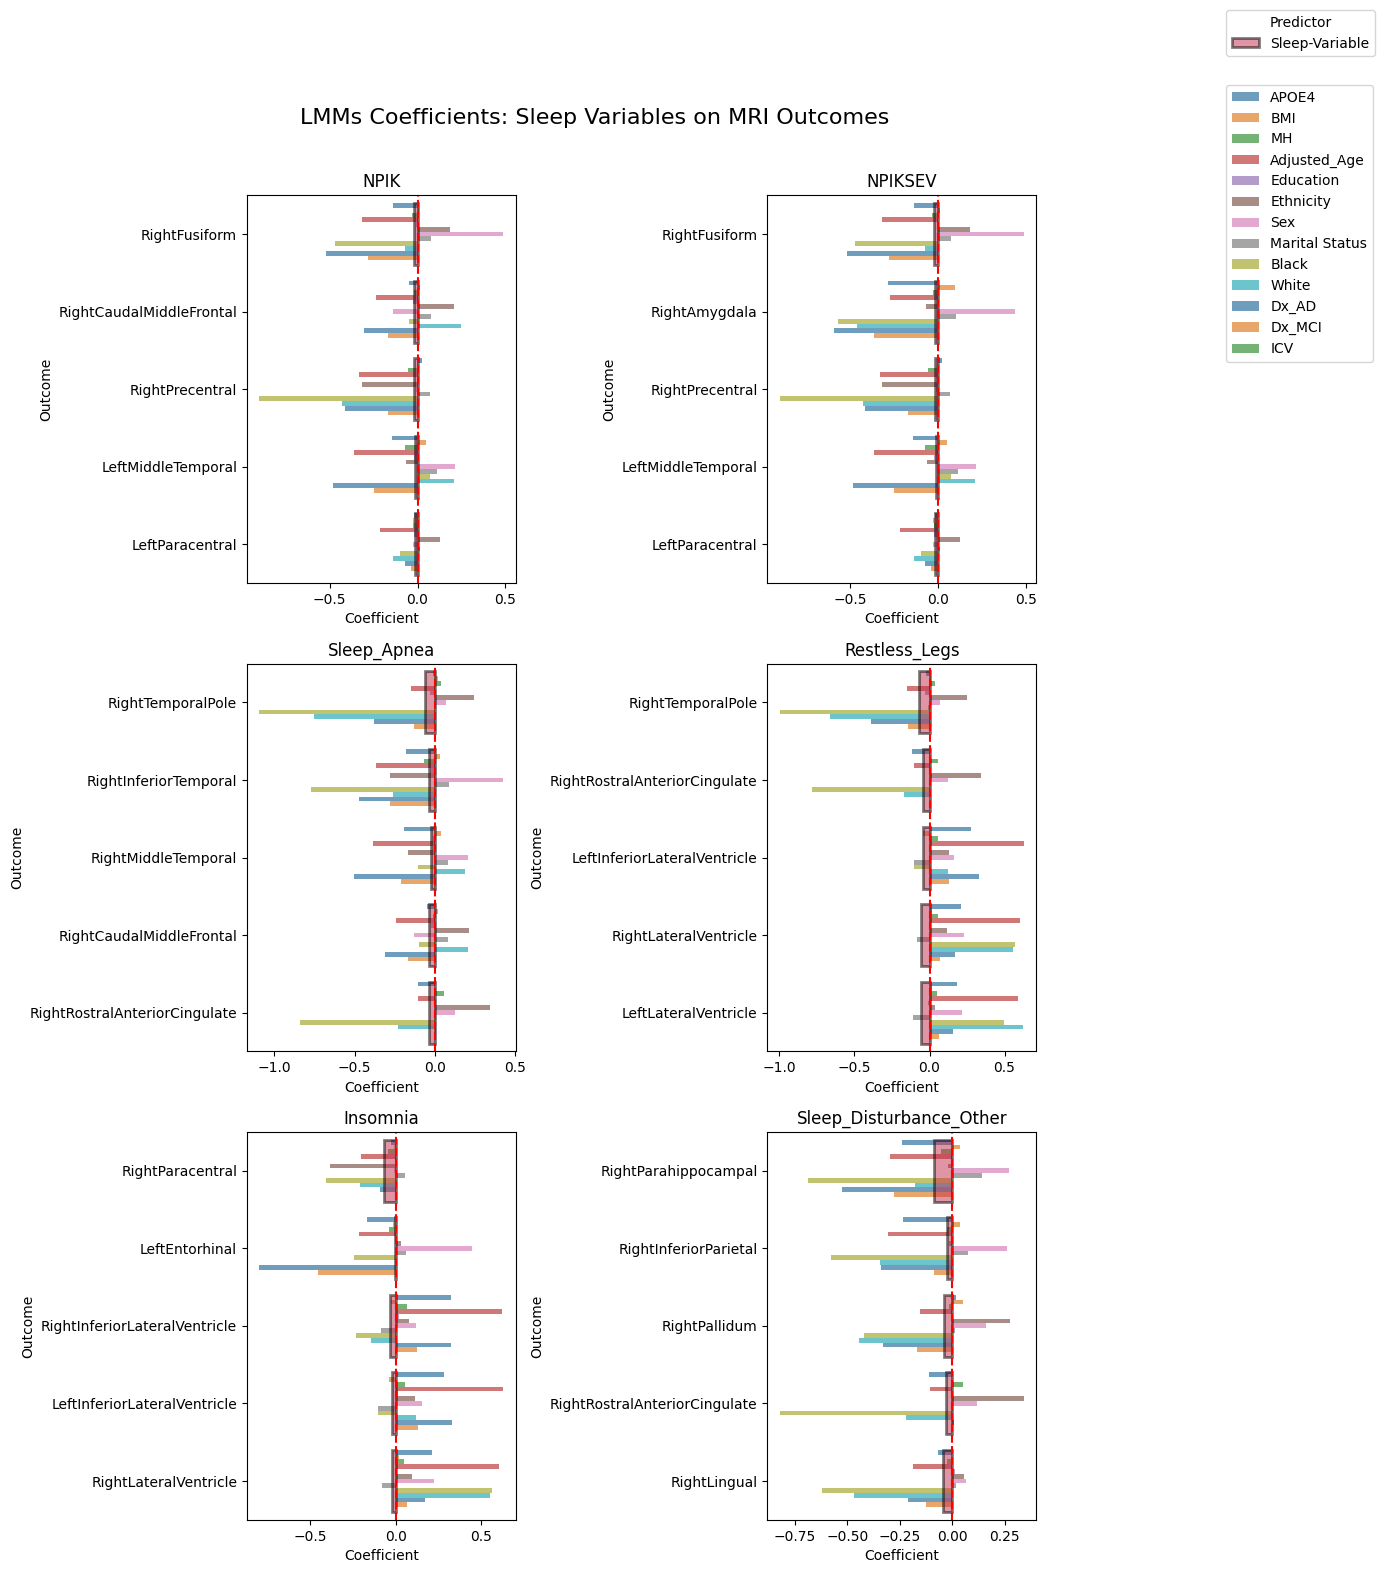

In [111]:
all_df_top = []

for sleep_var in LMM_results_mri_df_sd['Sleep_Variable'].unique():
    df_plot = LMM_results_mri_df_sd[LMM_results_mri_df_sd['Sleep_Variable'] == sleep_var]

    top_outcomes = (
        df_plot[df_plot['Feature'] == sleep_var].sort_values(by='Coefficient')
        .set_index('Outcome')['Coefficient']
        .abs()
        .head(5)
        .index
    )

    df_top = df_plot[df_plot['Outcome'].isin(top_outcomes)]
    all_df_top.append(df_top)

df_top_all = pd.concat(all_df_top, ignore_index=True)
plot_lmms_result(df_top_all, domain='MRI')

In [60]:
# for sleep_var in sleep_vars:
#     df_plot = LMM_results_cognitive_df_sd[LMM_results_cognitive_df_sd['Sleep_Variable'] == sleep_var]

#     plt.figure(figsize=(10, 8))
#     sns.barplot(
#         data=df_plot,
#         x='Coefficient',
#         y='Outcome',
#         hue='Feature',
#         palette='Set2'
#     )
#     plt.axvline(x=0, color='red', linestyle='--')
#     plt.title(f'LMM (Cognitive) - Predictors + {sleep_var}')
#     plt.xlabel('Coefficient')
#     plt.ylabel('Outcome')
#     plt.legend(title='Predictor', bbox_to_anchor=(1.05, 1), loc='upper left')
#     plt.tight_layout()

In [61]:
# for sleep_var in LMM_results_mri_df_sd['Sleep_Variable'].unique():
#     df_plot = LMM_results_mri_df_sd[LMM_results_mri_df_sd['Sleep_Variable'] == sleep_var]

#     top_outcomes = (
#         df_plot[df_plot['Feature'] == sleep_var]
#         .set_index('Outcome')['Coefficient']
#         .abs()
#         .sort_values(ascending=False)
#         .head(5)
#         .index
#     )

#     df_top = df_plot[df_plot['Outcome'].isin(top_outcomes)]

#     plt.figure(figsize=(10, 8))
#     sns.barplot(
#         data=df_top,
#         x='Coefficient',
#         y='Outcome',
#         hue='Feature',
#         dodge=True,
#         palette='Set2'
#     )

#     plt.axvline(x=0, color='red', linestyle='--')
#     plt.title(
#         f'LMM Coefficients for {sleep_var} + Covariates on Top 5 MRI Outcomes')
#     plt.xlabel('Coefficient')
#     plt.ylabel('MRI Outcome')
#     plt.legend(title='Predictor', bbox_to_anchor=(1.05, 1), loc='upper left')
#     plt.tight_layout()

In [62]:
flat_mri['Model_ID'].nunique(), flat_cog['Model_ID'].nunique()

(180, 30)

In [63]:
DX_bl_ = {"AD":0, "CN":1, "LMCI":2}
DX_ = {"CN":0,'Dementia':1, "MCI":2}

In [64]:
DX_bl_ = {v: k for k, v in DX_bl_.items()}
DX_ = {v: k for k, v in DX_.items()}

In [65]:
merge['DX_bl_decoded'] = merge['DX_bl'].map(DX_bl_)
merge['DX_decoded'] = merge['DX'].map(DX_)

In [66]:
dx_transitions = []

for rid, group in merge.groupby('RID'):
    dx_seq = group['DX_decoded'].dropna().tolist()
    dx_bl = group['DX_bl_decoded'].iloc[0]

    dx_set = set(dx_seq)

    dx_seq = ['AD' if d == 'Dementia' else d for d in dx_seq]
    dx_set = set(dx_seq)

    if len(dx_set) == 1 and dx_seq[0] == dx_bl:
        dx_status = 'Stable'
    elif dx_bl in ['CN', 'LMCI'] and 'AD' in dx_set:
        dx_status = 'Progressed'
    elif dx_bl == 'AD' and any(x in dx_set for x in ['CN', 'MCI', 'LMCI']):
        dx_status = 'Improved'
    else:
        dx_status = 'Mixed'

    dx_transitions.append({'RID': rid, 'DX_Transition': dx_status})

In [67]:
npiksev_transitions = []

for rid, group in merge.groupby('RID'):
    sev_values = group['NPIKSEV'].dropna().tolist()

    if len(sev_values) <= 1:
        trend = 'Stable'
    else:
        diffs = pd.Series(sev_values).diff().dropna()
        if all(d == 0 for d in diffs):
            trend = 'Stable'
        elif all(d <= 0 for d in diffs) and any(d < 0 for d in diffs):
            trend = 'Improved'
        elif all(d >= 0 for d in diffs) and any(d > 0 for d in diffs):
            trend = 'Progressed'
        else:
            trend = 'Mixed'

    npiksev_transitions.append({'RID': rid, 'NPIKSEV_Trend': trend})

In [68]:
merge['NPIKSEV'].value_counts()

0.0    1759
1.0     213
2.0      95
3.0      21
Name: NPIKSEV, dtype: int64

In [69]:
dx_transition_df = pd.DataFrame(dx_transitions)
npiksev_transition_df = pd.DataFrame(npiksev_transitions)

In [70]:
npiksev_transition_df['NPIKSEV_Trend'].value_counts()

Stable        335
Mixed         101
Progressed     59
Improved       27
Name: NPIKSEV_Trend, dtype: int64

In [71]:
dx_transition_df['DX_Transition'].value_counts()

Stable        273
Mixed         151
Progressed     95
Improved        3
Name: DX_Transition, dtype: int64

In [72]:
transition_summary = pd.merge(
    dx_transition_df, npiksev_transition_df, on='RID')

In [73]:
transition_summary.sort_values(by=['DX_Transition','NPIKSEV_Trend'],inplace=True)

In [74]:
transition_summary

,RID,DX_Transition,NPIKSEV_Trend
72,167,Improved,Mixed
70,162,Improved,Stable
301,739,Improved,Stable
138,331,Mixed,Improved
154,376,Mixed,Improved
...,...,...,...
493,1307,Stable,Stable
494,1308,Stable,Stable
507,1371,Stable,Stable
509,1379,Stable,Stable


In [75]:
import plotly.graph_objects as go 

In [76]:
df_long = transition_summary.copy()
df_long = df_long[['DX_Transition', 'NPIKSEV_Trend']]
df_long['Count'] = 1

color_map = {
    'Stable': 'black',
    'Improved': 'green',
    'Progressed': 'red',
    'Mixed': 'blue'
}
category_order = ['Stable', 'Improved', 'Progressed', 'Mixed']

df_long['Color'] = df_long['DX_Transition'].map(color_map)

df_long['DX_Transition'] = pd.Categorical(
    df_long['DX_Transition'], categories=category_order, ordered=True)
df_long['NPIKSEV_Trend'] = pd.Categorical(
    df_long['NPIKSEV_Trend'], categories=category_order, ordered=True)

grouped = df_long.groupby(
    ['DX_Transition', 'NPIKSEV_Trend', 'Color']).size().reset_index(name='Count')

fig = go.Figure(data=[
    go.Parcats(
        dimensions=[
            dict(label='Diagnosis Transition',
                 values=grouped['DX_Transition']),
            dict(label='Sleep Severity Trend', values=grouped['NPIKSEV_Trend'])
        ],
        line=dict(
            color=grouped['Color'].apply(lambda c: c),
            colorscale=None
        ),
        counts=grouped['Count']
    )
])

fig.update_layout(
    title='Parallel Categories Plot: Diagnosis vs. Sleep Severity Trends',
    font=dict(size=14)
)

fig.show()

In [77]:
flat_cog = LMM_results_cognitive_df[~LMM_results_cognitive_df['Feature'].isin(
    ['Intercept', 'Group Var'])]

sleep_vars = ['NPIK', 'NPIKSEV', 'Sleep_Apnea',
              'Restless_Legs', 'Insomnia', 'Sleep_Disturbance_Other']
table_df = flat_cog[flat_cog['Feature'].isin(sleep_vars)]

mean_table = table_df.groupby(['Outcome', 'Sleep_Variable']).agg({
    'Coefficient': 'mean',
    'P-Value': 'mean'
}).reset_index()

In [78]:
mean_table

,Outcome,Sleep_Variable,Coefficient,P-Value
0,ADNI_EF,Insomnia,0.028558,0.362627
1,ADNI_EF,NPIK,-0.004353,0.613617
2,ADNI_EF,NPIKSEV,-0.004200,0.647795
3,ADNI_EF,Restless_Legs,0.016663,0.598195
4,ADNI_EF,Sleep_Apnea,-0.018554,0.559471
5,ADNI_EF,Sleep_Disturbance_Other,-0.000358,0.991071
6,ADNI_EF2,Insomnia,0.020067,0.539598
7,ADNI_EF2,NPIK,-0.006841,0.430823
8,ADNI_EF2,NPIKSEV,-0.003075,0.739912
9,ADNI_EF2,Restless_Legs,0.017064,0.604706


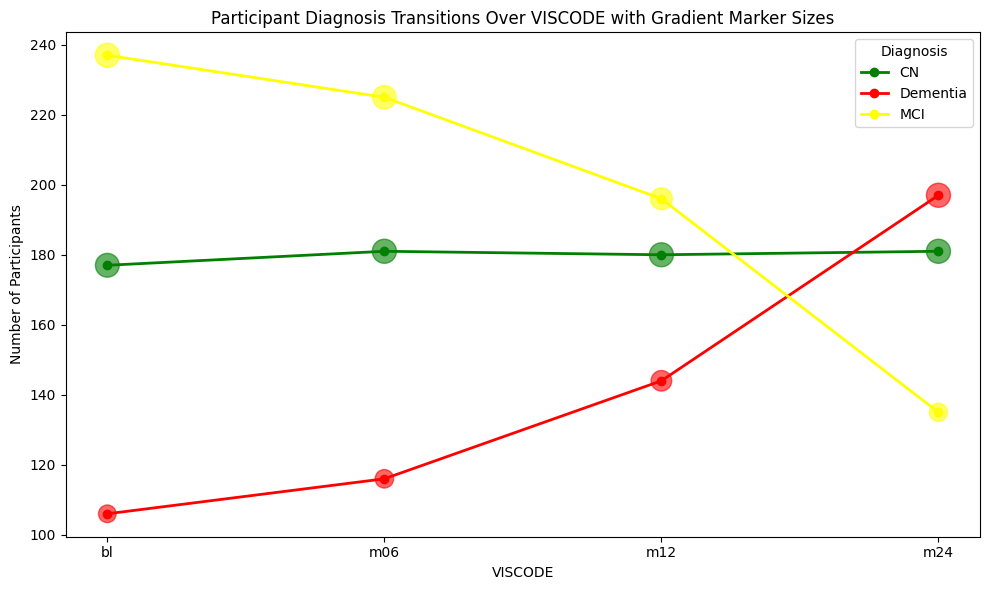

In [79]:
viscode_map = {0: 'bl', 1: 'm06', 2: 'm12', 3: 'm24'}
viscode_order = ['bl', 'm06', 'm12', 'm24']

df_plot = merge.copy()

df_plot['VISCODE_label'] = df_plot['VISCODE'].map(viscode_map)

df_plot['Diagnosis'] = df_plot['DX_decoded']

counts = df_plot.groupby(['VISCODE_label', 'Diagnosis'])[
    'RID'].nunique().reset_index(name='Participant_Count')

counts['VISCODE_label'] = pd.Categorical(
    counts['VISCODE_label'], categories=viscode_order, ordered=True)

counts = counts.sort_values('VISCODE_label')

color_map = {'MCI': 'yellow', 'CN': 'green', 'Dementia': 'red'}

plt.figure(figsize=(10, 6))

for diagnosis, group in counts.groupby('Diagnosis'):
    plt.plot(group['VISCODE_label'], group['Participant_Count'],
             label=diagnosis,
             color=color_map.get(diagnosis, 'gray'),
             linewidth=2,
             marker='o')

    sizes = (group['Participant_Count'] /
             group['Participant_Count'].max()) * 300 
    plt.scatter(group['VISCODE_label'], group['Participant_Count'],
                color=color_map.get(diagnosis, 'gray'),
                s=sizes,
                alpha=0.6)

plt.title('Participant Diagnosis Transitions Over VISCODE with Gradient Marker Sizes')
plt.xlabel('VISCODE')
plt.ylabel('Number of Participants')
plt.legend(title='Diagnosis')
plt.tight_layout()
plt.show()

C:\Users\anisr\AppData\Local\Temp\ipykernel_17716\1672972105.py:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




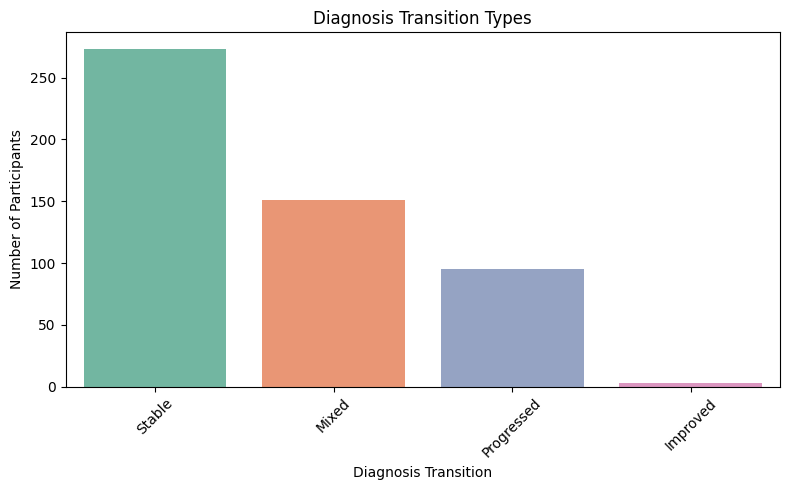

In [80]:
dx_counts = transition_summary['DX_Transition'].value_counts().reset_index()
dx_counts.columns = ['Transition', 'Count']

plt.figure(figsize=(8, 5))
sns.barplot(data=dx_counts, x='Transition', y='Count', palette='Set2')
plt.title('Diagnosis Transition Types')
plt.xlabel('Diagnosis Transition')
plt.ylabel('Number of Participants')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

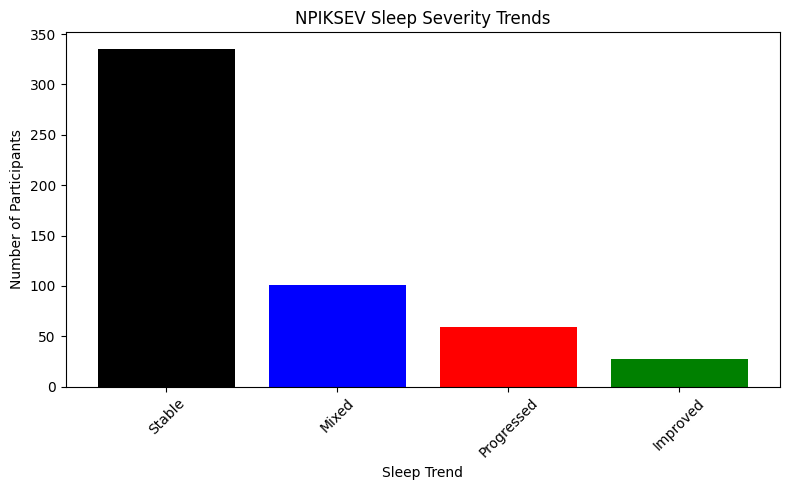

In [81]:
sleep_colors = {
    'Stable': 'black',
    'Improved': 'green',
    'Progressed': 'red',
    'Mixed': 'blue'
}

sleep_counts = transition_summary['NPIKSEV_Trend'].value_counts().reset_index()
sleep_counts.columns = ['Trend', 'Count']
sleep_counts['Color'] = sleep_counts['Trend'].map(sleep_colors)
plt.figure(figsize=(8, 5))
bars = plt.bar(sleep_counts['Trend'],
               sleep_counts['Count'], color=sleep_counts['Color'])
plt.title('NPIKSEV Sleep Severity Trends')
plt.xlabel('Sleep Trend')
plt.ylabel('Number of Participants')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()